# Covariate Analysis (Separate Managed Areas)

This document includes Python codes that conduct correlation analysis between water quality parameters and water depth, LDI, population density, and water flow.

The analysis is conducted in Charlotte Harbor, Estero Bay, Big Bend, Biscayne Bay, and Matlacha Pass.

* [1.Data Preprocess](#preprocessing)
    * [1.1 Preset Parameters](#preset)
    * [1.2 Preprocess_data](#preprocess)
    * [1.3 Select Parameters and Areas](#select)
    
* [2. Extract Raster Value to Point](#extract_raster_value_to_points)
* [3. Regression Analysis](#reg_result)
* [4. Regression Result](#reg_result_ch)
    * [4.1 Charlotte Harbor](#reg_result_ch)
        * [4.1.1 Water Depth](#reg_result_ch_wd)
        * [4.1.2 Land Development Index](#reg_result_ch_ldi_huc_lss)
        * [4.1.3 New_Land Development Index](#reg_result_ch_new_ldi)
        * [4.1.4 Population Density](#reg_result_ch_popden)
        * [4.1.5 Water Flow](#reg_result_ch_WF)
    * [4.2 Estero Bay](#reg_result_eb)
        * [4.2.1 Water Depth](#reg_result_eb_wd)
        * [4.2.2 Land Development Index](#reg_result_eb_ldi)
        * [4.2.3 New_Land Development Index](#reg_result_eb_new_ldi)
        * [4.2.4 Population Density](#reg_result_eb_popden)
        * [4.2.5 Water Flow](#reg_result_eb_wf)
    * [4.3 Big Bend](#reg_result_bb)
        * [4.3.1 Water Depth](#reg_result_bb_wd)
        * [4.3.2 Land Development Index](#reg_result_bb_ldi)
        * [4.3.3 New_Land Development Index](#reg_result_bb_new_ldi)
        * [4.3.4 Population Density](#reg_result_bb_popden)
        * [4.3.5 Water Flow](#reg_result_bb_wf)
    * [4.4 Biscayne Bay Aquatic Preserve](#reg_result_bbap)
        * [4.4.1 Water Depth](#reg_result_bbap_wd)
        * [4.4.2 Land Development Index](#reg_result_bbap_ldi)
        * [4.4.3 New_Land Development Index](#reg_result_bbap_new_ldi)
        * [4.4.4 Population Density](#reg_result_bbap_popden)
        * [4.4.5 Water Flow](#reg_result_bbap_wf)
    * [4.5 Matlacha Pass Aquatic Preserve](#reg_result_mp)
        * [4.5.1 Water Depth](#reg_result_mp_wd)
        * [4.5.2 Land Development Index](#reg_result_mp_ldi)
        * [4.5.3 New_Land Development Index](#reg_result_mp_new_ldi)
        * [4.5.4 Population Density](#reg_result_mp_popden)
        * [4.5.5 Water Flow](#reg_result_mp_wf)

In [1]:
import geopandas as gpd
import rasterio as rio
from scipy.stats import pearsonr
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os, re, importlib, warnings
from pathlib import Path
from datetime import datetime

## Create a copy for original misc.covariate
import sys
sys.path.append('..')
import misc.covariateCopy
warnings.filterwarnings(action='once')
importlib.reload(misc.covariateCopy) # reload the covariate module after edit

<module 'misc.covariateCopy' from '/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py'>

# 1. Data Preprocessing <a class="anchor" id="preprocessing"></a>
Define the water depth, water quality parameter, and LDI folders

In [2]:
path = '/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/'
path_gis = '/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/'
WQPara_folder = path_gis+'WQPara/'

# Test for function
#WQPara_folder1 = path_gis+'WQPara1/'

# path = 'E:/Projects/SEACAR_WQ_Pilot/'
# path_gis = 'E:/Projects/SEACAR_WQ_Pilot/GIS_data/'
# WQPara_folder = path+'Correlation_Analysis/WQPara/'

# Define the water depth, water quality parameter, and LDI folders
path_LDI = path_gis+'LDI/'
# Define the New LDI: LDI_HUC12River_LogScaleSUM_prj.tif
path_NewLDI = path_gis + 'New_LDI/'
WaterDepth = path_gis + 'NCEI_DEM_30m.tif'
LDI_HUC_LSS = path_LDI + 'LDI_HUC12River_LogScaleSUM.tif'
New_LDI_HUC_LSS = path_NewLDI + 'LDI_HUC12River_LogScaleSUM_prj.tif'
PopDen = path_gis + 'PopDens_mi2_HUC10.tif'
# Define the water flow in dry and wet season
WF_Dry = path_gis + 'WaterFlow_Winter_MaxCFS.tif'
WF_Wet = path_gis + 'WaterFlow_Summer_MaxCFS.tif'

In [3]:
dfDis_orig = pd.read_csv(path + r"discrete_0214.csv")
dfCon_orig = pd.read_csv(path + r"continuous_0214.csv")

/var/folders/cz/zp745plj37jdzfz0mjlpjwj40000gn/T/ipykernel_13997/156691913.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfDis_orig = pd.read_csv(path + r"discrete_0214.csv")


# 1.1 Preset function parameters <a class="anchor" id="preset"></a>


In [4]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]

dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte_Harbor','Big Bend Seagrasses Aquatic Preserve':'Big_Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM_Reserve','Estero Bay Aquatic Preserve':'Estero_Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne_Bay','Matlacha Pass Aquatic Preserve':'Matlacha_Pass_AP',
                'Lemon Bay Aquatic Preserve':'Lemon_Bay','Cape Haze Aquatic Preserve':'Cape_Haze_AP','Pine Island Sound Aquatic Preserve':'Pine_Island'}
dictUnits   = {'Salinity':'ppt','Total Nitrogen': 'mg/L','Dissolved Oxygen': 'mg/L','Turbidity': 'NTU', 'Secchi Depth': 'm'}
listArea    = dfCon_orig["ManagedAreaName"].unique()
dictPara = {'Salinity':'SA', 'Total Nitrogen': 'TN', 'Dissolved Oxygen': 'DO', 'Turbidity': 'TUR', 'Secchi Depth': 'SD'} 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]

# Interested areas
areas = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve', 'Big Bend Seagrasses Aquatic Preserve', 'Estero Bay Aquatic Preserve', 'Biscayne Bay Aquatic Preserve','Matlacha Pass Aquatic Preserve']
# Interested parameters
parameters = ['Dissolved Oxygen','Salinity','Total Nitrogen']
SpatialRef = '3086'

# dry season period
dry_start_16, dry_end_17 = '11/01/2016', '04/30/2017'
dry_start_17, dry_end_18 = '11/01/2017', '04/30/2018'

# wet season period
wet_start_17, wet_end_17 = '05/01/2017', '10/31/2017'
wet_start_18, wet_end_18 = '05/01/2018', '10/31/2018'

# time periods of the dry and wet seasons between 2016 to 2018
time_periods_dry = [(dry_start_16, dry_end_17), (dry_start_17, dry_end_18)]
time_periods_wet = [(wet_start_17, wet_end_17), (wet_start_18, wet_end_18)]

# 1.2 Preprocess dataframes <a class="anchor" id="preprocess"></a>

In [5]:
dfDis = misc.covariateCopy.preprocess2(dfDis_orig, col_ls, para_ls)
dfCon = misc.covariateCopy.preprocess2(dfCon_orig, col_ls, para_ls)

# 1.3 Select Parameters and Areas <a class="anchor" id="select"></a>
Create shapefiles for 'Dissolved Oxygen','Salinity','Total Nitrogen' in five areas between 2016 and 2018, separated by dry and wet season

In [6]:
misc.covariateCopy.create_combined_shapefiles(dfDis, dfCon, areas, params = parameters, time_periods_dry=time_periods_dry, time_periods_wet=time_periods_wet, folder = WQPara_folder, SpatialRef=SpatialRef)

Processing multiple parameters: ['Dissolved Oxygen', 'Salinity', 'Total Nitrogen'] for area: Charlotte_Harbor with seasonality between （2016 - 2018）.


/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

Processing multiple parameters: ['Dissolved Oxygen', 'Salinity', 'Total Nitrogen'] for area: Big_Bend with seasonality between （2016 - 2018）.


/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

Processing multiple parameters: ['Dissolved Oxygen', 'Salinity', 'Total Nitrogen'] for area: Estero_Bay with seasonality between （2016 - 2018）.


/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

Processing multiple parameters: ['Dissolved Oxygen', 'Salinity', 'Total Nitrogen'] for area: Biscayne_Bay with seasonality between （2016 - 2018）.


/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

Processing multiple parameters: ['Dissolved Oxygen', 'Salinity', 'Total Nitrogen'] for area: Matlacha_Pass with seasonality between （2016 - 2018）.


/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/git/misc/covariateCopy.py:266: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(folder + filename, driver='ESRI Shapefile', crs="EPSG:" + SpatialRef)
/Users/cong/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use 

In [7]:
# Test the function, here is the previous function
# misc.covariateCopy.create_shapefiles(dfDis, dfCon, areas, parameters,time_periods_dry,time_periods_wet, WQPara_folder1,SpatialRef )

# 2. Extract values from covariates rasters to observation points <a class="anchor" id="extract_raster_value_to_points"></a>

In [8]:
# Avoid naming conflicts
misc.covariateCopy.remove_csv_files(WQPara_folder)

In [9]:
column_name = 'Water_Depth'
misc.covariateCopy.generate_csv_files_con(WQPara_folder, WaterDepth, column_name)

Created /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Charlotte_Harbor.csv
Created /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Estero_Bay.csv
Created /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/DO_Wet_2016_2018_Matlacha_Pass.csv
Created /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Created /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Big_Bend.csv
Created /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Biscayne_Bay.csv
Created /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Wet_2016_2018_Big_Bend.csv
Created /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Biscayne_Bay.csv
Created /

In [10]:
# Append LDI to the csv file
column_LDI_HUC_LSS = 'LDI_HUC_LSS'
misc.covariateCopy.generate_csv_files_con(WQPara_folder,LDI_HUC_LSS, column_LDI_HUC_LSS)

Appended LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Estero_Bay.csv
Appended LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/DO_Wet_2016_2018_Matlacha_Pass.csv
Appended LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Big_Bend.csv
Appended LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Biscayne_Bay.csv
Appended LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Wet_2016_2018_Big_Bend.csv
Appended LDI_HUC_LSS t

In [11]:
column_New_LDI_HUC_LSS = 'New_LDI_HUC_LSS'
misc.covariateCopy.generate_csv_files_con(WQPara_folder,New_LDI_HUC_LSS, column_New_LDI_HUC_LSS)

Appended New_LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Charlotte_Harbor.csv
Appended New_LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Estero_Bay.csv
Appended New_LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/DO_Wet_2016_2018_Matlacha_Pass.csv
Appended New_LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended New_LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Big_Bend.csv
Appended New_LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Biscayne_Bay.csv
Appended New_LDI_HUC_LSS to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Wet_2016_2018_Big_Ben

In [12]:
column_PopDen = 'PopDen'
misc.covariateCopy.generate_csv_files_con(WQPara_folder,PopDen, column_PopDen)

Appended PopDen to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Charlotte_Harbor.csv
Appended PopDen to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Estero_Bay.csv
Appended PopDen to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/DO_Wet_2016_2018_Matlacha_Pass.csv
Appended PopDen to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended PopDen to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Big_Bend.csv
Appended PopDen to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Biscayne_Bay.csv
Appended PopDen to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Wet_2016_2018_Big_Bend.csv
Appended PopDen to /Users/cong/Downloads/WaterQualityProj

In [13]:
column_WF_Dry = 'WF_Dry'
misc.covariateCopy.generate_csv_files_con(WQPara_folder, WF_Dry, column_WF_Dry)

Appended WF_Dry to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Charlotte_Harbor.csv
Appended WF_Dry to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Estero_Bay.csv
Skipping DO_Wet_2016_2018_Matlacha_Pass.shp due to mismatched season in column 'WF_Dry'
Appended WF_Dry to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended WF_Dry to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Big_Bend.csv
Appended WF_Dry to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Dry_2016_2018_Biscayne_Bay.csv
Skipping TN_Wet_2016_2018_Big_Bend.shp due to mismatched season in column 'WF_Dry'
Appended WF_Dry to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Dry_2016_2018_Biscayne_Bay.csv
Appended WF_Dry to 

In [14]:
column_WF_Wet = 'WF_Wet'
misc.covariateCopy.generate_csv_files_con(WQPara_folder,WF_Wet, column_WF_Wet)

Skipping TN_Dry_2016_2018_Charlotte_Harbor.shp due to mismatched season in column 'WF_Wet'
Skipping SA_Dry_2016_2018_Estero_Bay.shp due to mismatched season in column 'WF_Wet'
Appended WF_Wet to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/DO_Wet_2016_2018_Matlacha_Pass.csv
Skipping SA_Dry_2016_2018_Big_Bend.shp due to mismatched season in column 'WF_Wet'
Skipping TN_Dry_2016_2018_Big_Bend.shp due to mismatched season in column 'WF_Wet'
Skipping SA_Dry_2016_2018_Biscayne_Bay.shp due to mismatched season in column 'WF_Wet'
Appended WF_Wet to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/TN_Wet_2016_2018_Big_Bend.csv
Skipping TN_Dry_2016_2018_Biscayne_Bay.shp due to mismatched season in column 'WF_Wet'
Skipping DO_Dry_2016_2018_Biscayne_Bay.shp due to mismatched season in column 'WF_Wet'
Appended WF_Wet to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/SA_Wet_2016_2018_Big_Bend.

# 3. Regression analysis <a class="anchor" id="reg_analysis"></a>

Funtion to calculate linear regression

Run OSL regressions for all covariates

In [68]:
# First remove result files before generate them
misc.covariateCopy.remove_result_files(WQPara_folder)

# Calculated regression
csv_folder = WQPara_folder

variable_name = 'Water_Depth'
# Remove the outlier
outlier_file = os.path.join(WQPara_folder, 'SA_Wet_2016_2018_Big_Bend.csv')
exclude_index_dict = {outlier_file: 84}
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_WD, outputs_WD = misc.covariateCopy.print_regression_result(csv_folder,variable_name, output_path,exclude_index_dict)

variable_name = 'LDI_HUC_LSS'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_HUC_LSS, outputs_LDI_HUC_LSS = misc.covariateCopy.print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'New_LDI_HUC_LSS'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_New_LDI_HUC_LSS,outputs_New_LDI_HUC_LSS = misc.covariateCopy.print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'PopDen'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_PopDen,outputs_PopDen = misc.covariateCopy.print_regression_result(csv_folder,variable_name,output_path)

variable_name = 'WF_Dry'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_WF_Dry, outputs_WF_Dry = misc.covariateCopy.print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'WF_Wet'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_WF_Wet, outputs_WF_Wet = misc.covariateCopy.print_regression_result(csv_folder,variable_name, output_path)

# Combine the water flow in dry and wet season
combined_waterflow_results = misc.covariateCopy.combine_regression_results(results_WF_Dry, results_WF_Wet)
combined_waterflow_outputs = misc.covariateCopy.combine_regression_results(outputs_WF_Dry, outputs_WF_Wet)

Regression results written to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/regression_results_Water_Depth.xlsx
Regression results written to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/regression_results_LDI_HUC_LSS.xlsx
Regression results written to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/regression_results_New_LDI_HUC_LSS.xlsx
Regression results written to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/regression_results_PopDen.xlsx
Regression results written to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/regression_results_WF_Dry.xlsx
Regression results written to /Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/WQPara/regression_results_WF_Wet.xlsx


# 4. Results of Regression Analysis <a class="anchor" id="reg_result"></a>
## 4.1 Charlotte Harbor <a class="anchor" id="reg_result_ch"></a>
### 4.1.1 Water Depth <a class="anchor" id="reg_result_ch_wd"></a>

In [16]:
results_WD[results_WD['Area'] == 'Charlotte_Harbor']

Dependent  Independent              Area       Year Season  \
2   Dissolved Oxygen  Water_Depth  Charlotte_Harbor  2016-2018    Dry   
7   Dissolved Oxygen  Water_Depth  Charlotte_Harbor  2016-2018    Wet   
12          Salinity  Water_Depth  Charlotte_Harbor  2016-2018    Dry   
17          Salinity  Water_Depth  Charlotte_Harbor  2016-2018    Wet   
22    Total Nitrogen  Water_Depth  Charlotte_Harbor  2016-2018    Dry   
27    Total Nitrogen  Water_Depth  Charlotte_Harbor  2016-2018    Wet   

    Coefficient  R-squared   p-value  
2     -0.007030   0.000589     0.780  
7     -0.001775   0.000099     0.973  
12    -0.541819   0.222279  0.000 **  
17    -0.662557   0.214780     0.129  
22    -0.008449   0.075667     0.157  
27     0.005695   0.059115     0.195

Scatter plots and regression lines

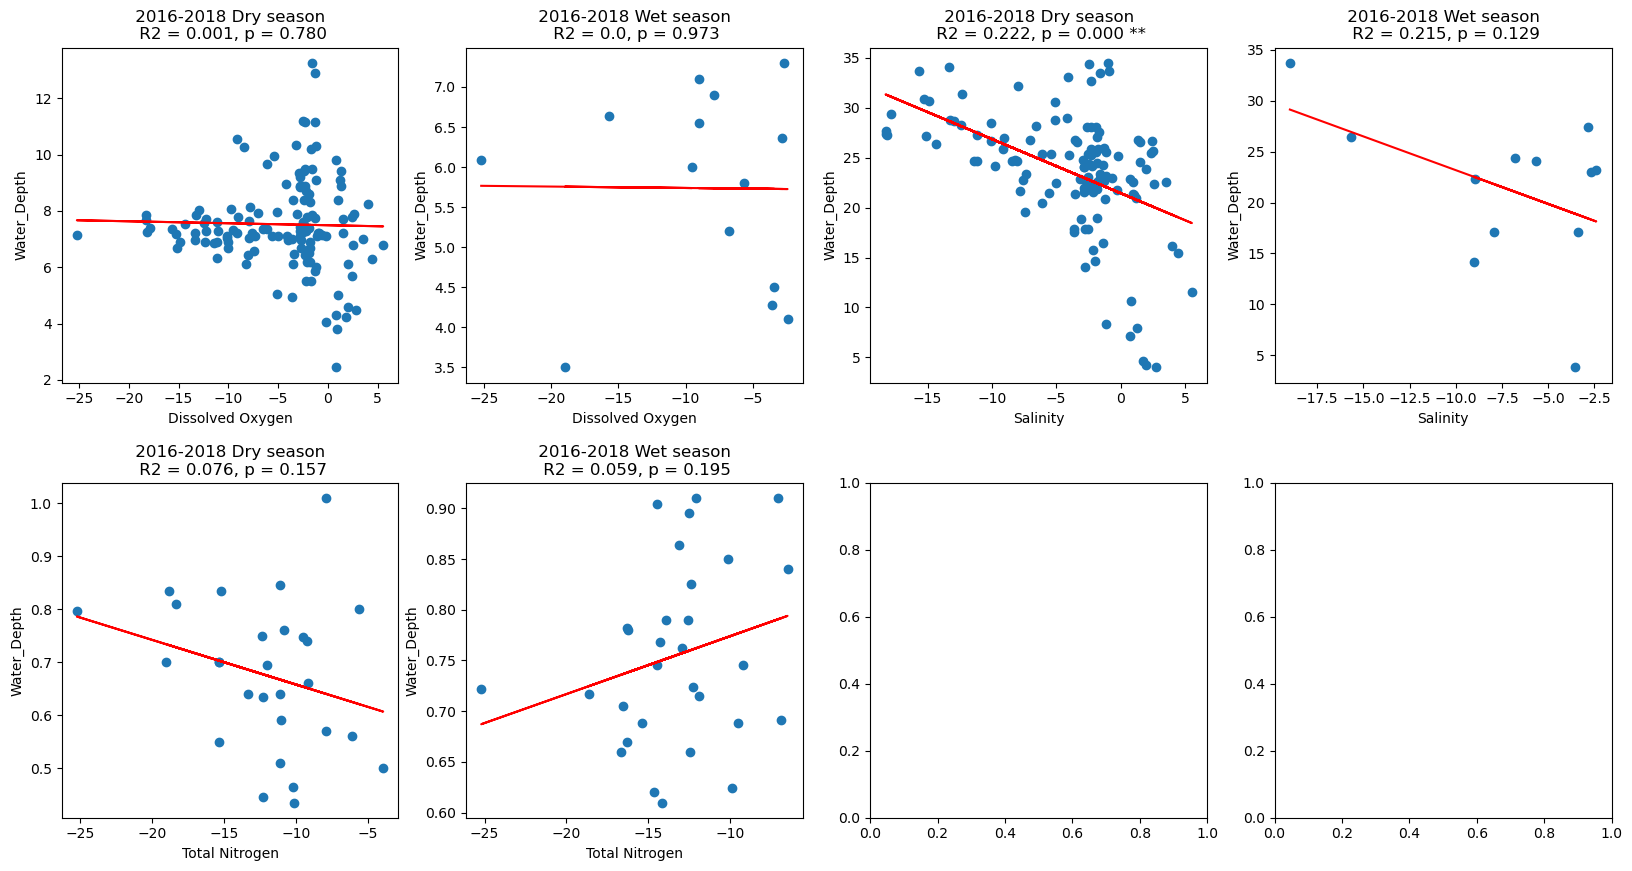

In [17]:
misc.covariateCopy.plot_regression(outputs_WD[outputs_WD['Area']=='Charlotte_Harbor'])

### 4.1.2 Land development index (LDI_HUC_LSS) <a class="anchor" id="reg_result_ch_ldi"></a>

In [18]:
results_LDI_HUC_LSS[results_LDI_HUC_LSS['Area'] == 'Charlotte_Harbor']

Dependent  Independent              Area       Year Season  \
2   Dissolved Oxygen  LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Dry   
7   Dissolved Oxygen  LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Wet   
12          Salinity  LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Dry   
17          Salinity  LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Wet   
22    Total Nitrogen  LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Dry   
27    Total Nitrogen  LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Wet   

    Coefficient  R-squared   p-value  
2     -0.208872   0.152161  0.000 **  
7     -0.129781   0.072806     0.351  
12    -1.069257   0.291334  0.000 **  
17    -1.026040   0.134928     0.240  
22     0.024356   0.042010     0.295  
27     0.002824   0.001406     0.844

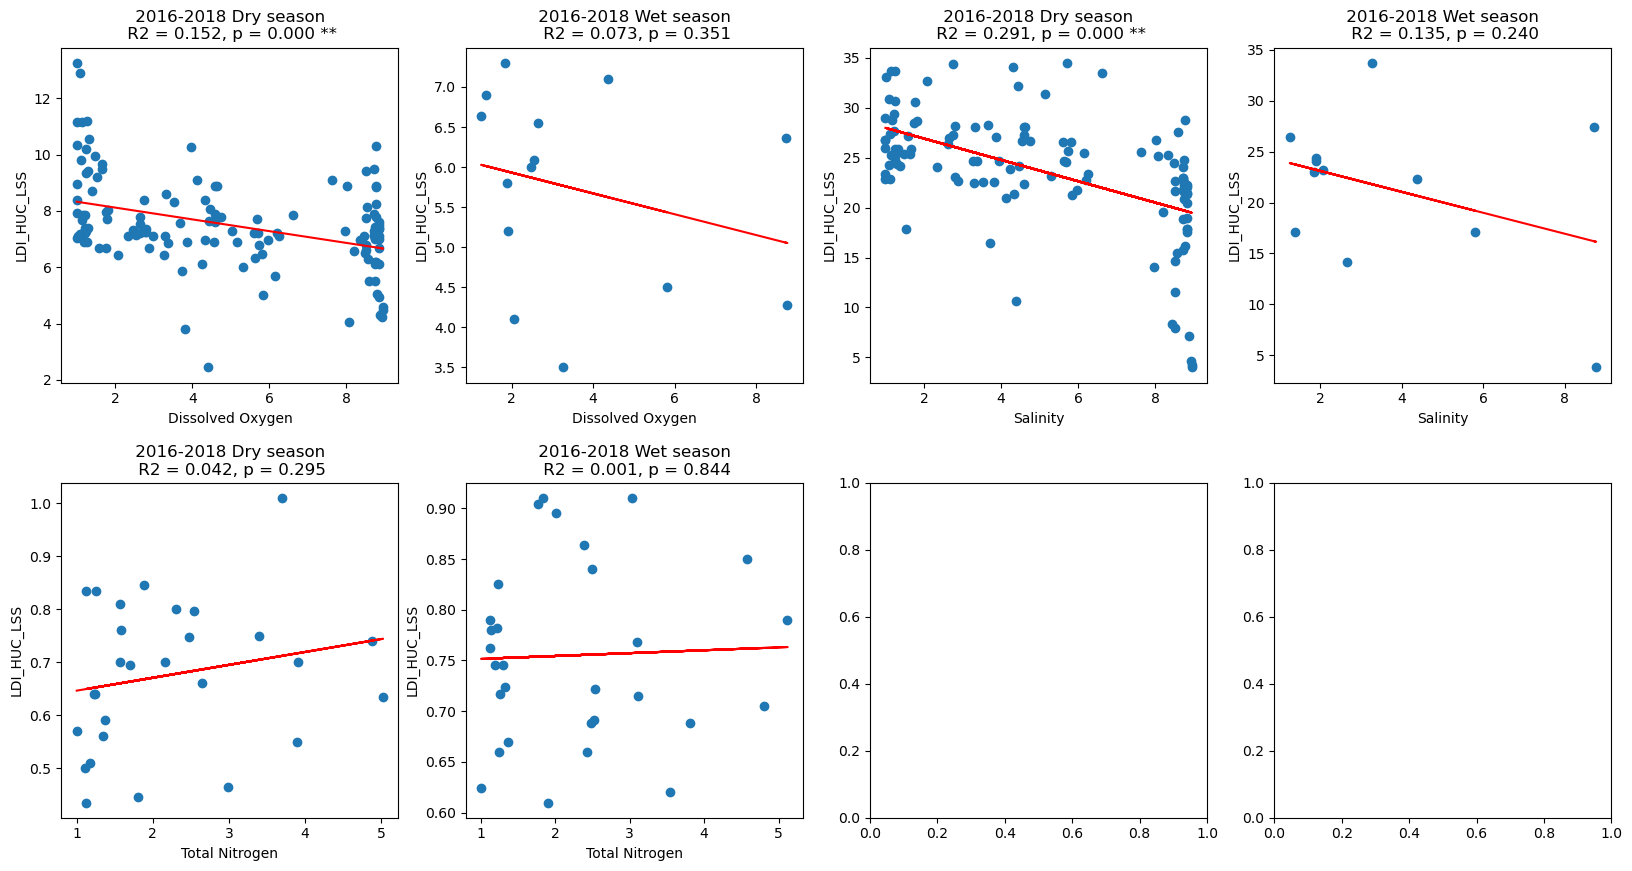

In [19]:
misc.covariateCopy.plot_regression(outputs_LDI_HUC_LSS[outputs_LDI_HUC_LSS['Area'] == 'Charlotte_Harbor'])

### 4.1.3 Land development index (New_LDI_HUC_LSS) <a class="anchor" id="reg_result_ch_new_ldi"></a>

In [20]:
results_New_LDI_HUC_LSS[results_New_LDI_HUC_LSS['Area'] == 'Charlotte_Harbor']

Dependent      Independent              Area       Year Season  \
2   Dissolved Oxygen  New_LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Dry   
7   Dissolved Oxygen  New_LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Wet   
12          Salinity  New_LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Dry   
17          Salinity  New_LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Wet   
22    Total Nitrogen  New_LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Dry   
27    Total Nitrogen  New_LDI_HUC_LSS  Charlotte_Harbor  2016-2018    Wet   

    Coefficient  R-squared   p-value  
2     -0.208770   0.151957  0.000 **  
7     -0.128850   0.071583     0.355  
12    -1.069820   0.291537  0.000 **  
17    -1.027319   0.134904     0.240  
22     0.024398   0.042145     0.295  
27     0.002711   0.001307     0.850

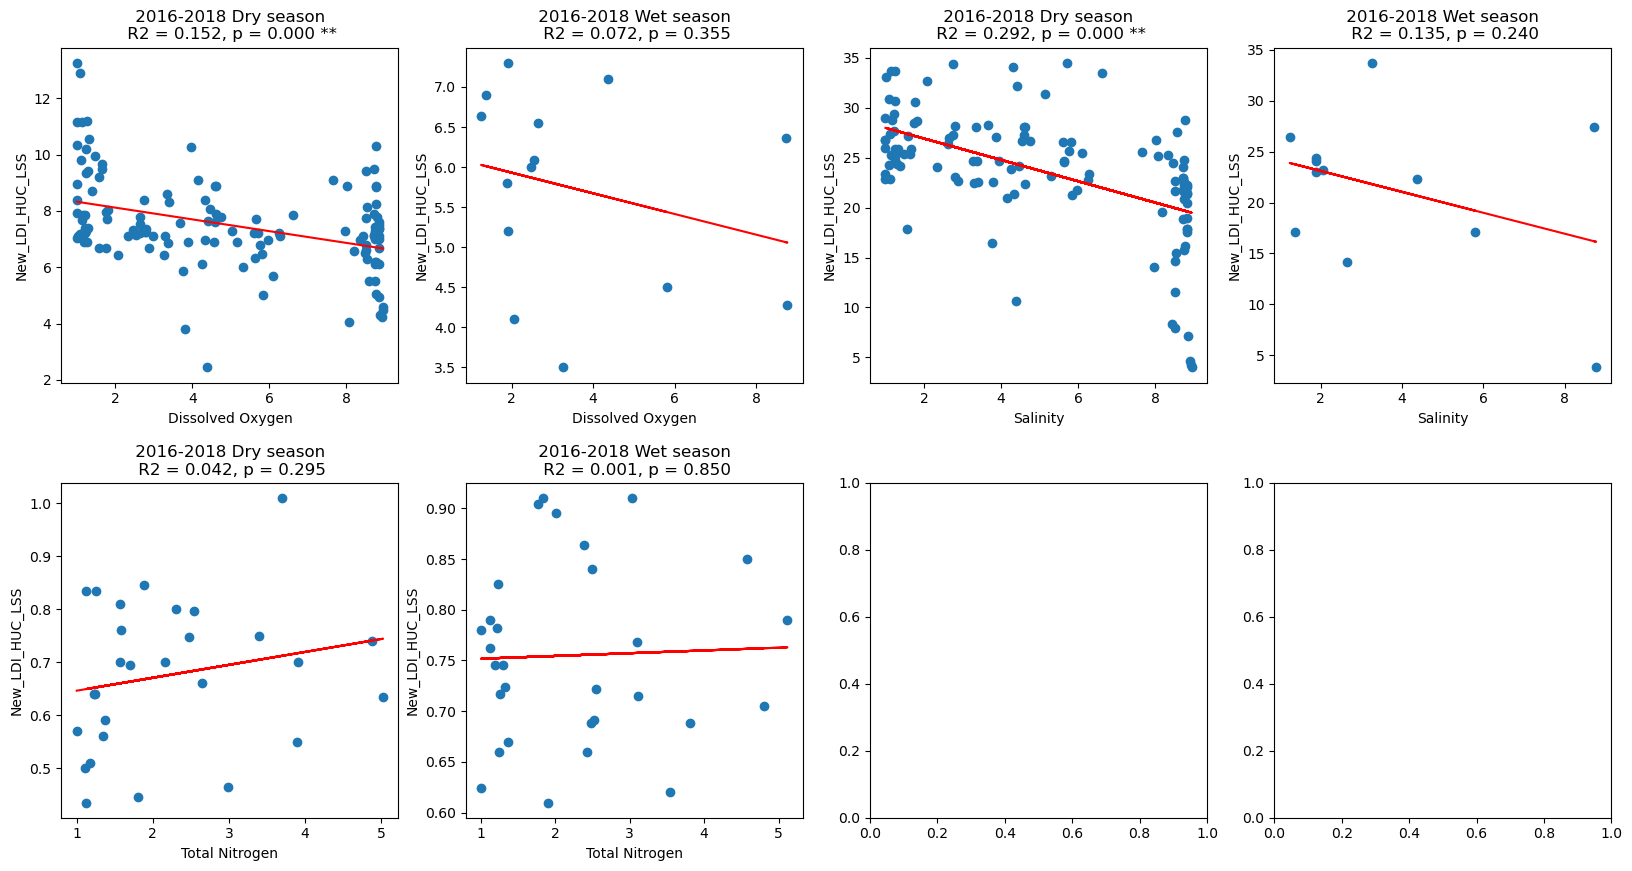

In [21]:
misc.covariateCopy.plot_regression(outputs_New_LDI_HUC_LSS[outputs_New_LDI_HUC_LSS['Area'] == 'Charlotte_Harbor'])

### 4.1.4 Population Density (PopDen) <a class="anchor" id="reg_result_ch_popden"></a>

In [22]:
results_PopDen[results_PopDen['Area'] == 'Charlotte_Harbor']

Dependent Independent              Area       Year Season  \
2   Dissolved Oxygen      PopDen  Charlotte_Harbor  2016-2018    Dry   
7   Dissolved Oxygen      PopDen  Charlotte_Harbor  2016-2018    Wet   
12          Salinity      PopDen  Charlotte_Harbor  2016-2018    Dry   
17          Salinity      PopDen  Charlotte_Harbor  2016-2018    Wet   
22    Total Nitrogen      PopDen  Charlotte_Harbor  2016-2018    Dry   
27    Total Nitrogen      PopDen  Charlotte_Harbor  2016-2018    Wet   

    Coefficient  R-squared   p-value  
2      0.000563   0.019925     0.102  
7     -0.000676   0.082455     0.320  
12    -0.004855   0.104869  0.000 **  
17    -0.008561   0.372598   0.035 *  
22    -0.000135   0.202206   0.016 *  
27     0.000033   0.026110     0.394

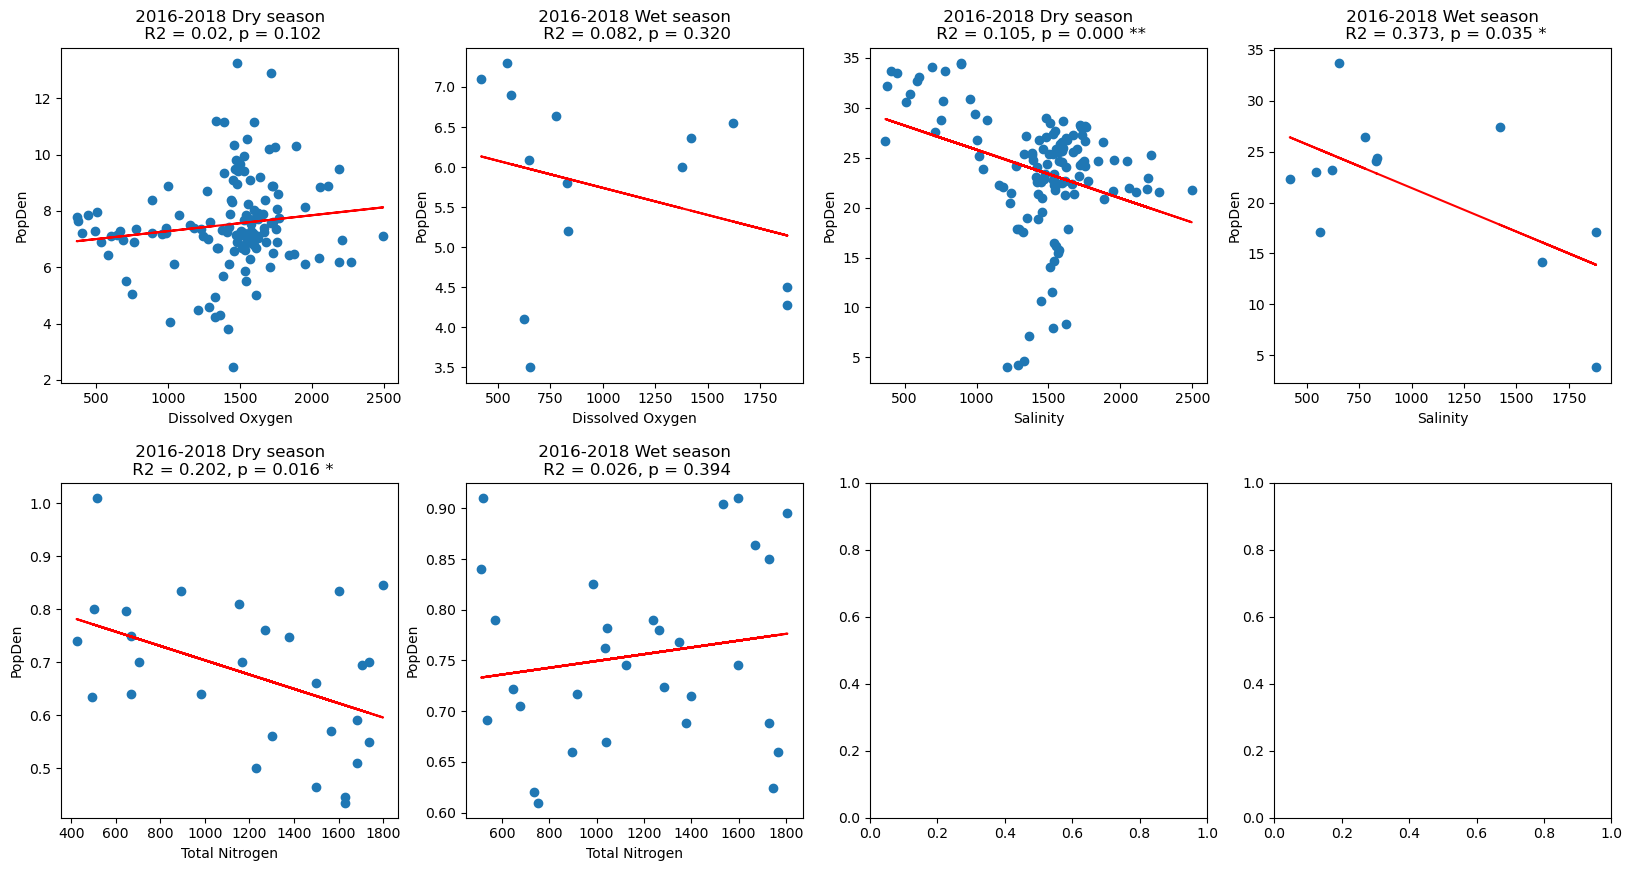

In [23]:
misc.covariateCopy.plot_regression(outputs_PopDen[outputs_PopDen['Area'] == 'Charlotte_Harbor'])

### 4.1.5 Water Flow (combined_waterflow_results) <a class="anchor" id="reg_result_ch_WF"></a>

In [24]:
combined_waterflow_results[combined_waterflow_results['Area'] == 'Charlotte_Harbor']

Dependent Independent              Area       Year Season  \
2   Dissolved Oxygen  Water_Flow  Charlotte_Harbor  2016-2018    Dry   
7   Dissolved Oxygen  Water_Flow  Charlotte_Harbor  2016-2018    Wet   
13          Salinity  Water_Flow  Charlotte_Harbor  2016-2018    Wet   
17          Salinity  Water_Flow  Charlotte_Harbor  2016-2018    Dry   
20    Total Nitrogen  Water_Flow  Charlotte_Harbor  2016-2018    Wet   
25    Total Nitrogen  Water_Flow  Charlotte_Harbor  2016-2018    Dry   

    Coefficient  R-squared   p-value  
2      0.000272   0.105923  0.000 **  
7     -0.000102   0.196345     0.113  
13    -0.001070   0.628064  0.002 **  
17     0.000844   0.080272  0.001 **  
20     0.000077   0.203428   0.012 *  
25    -0.000194   0.204182   0.016 *

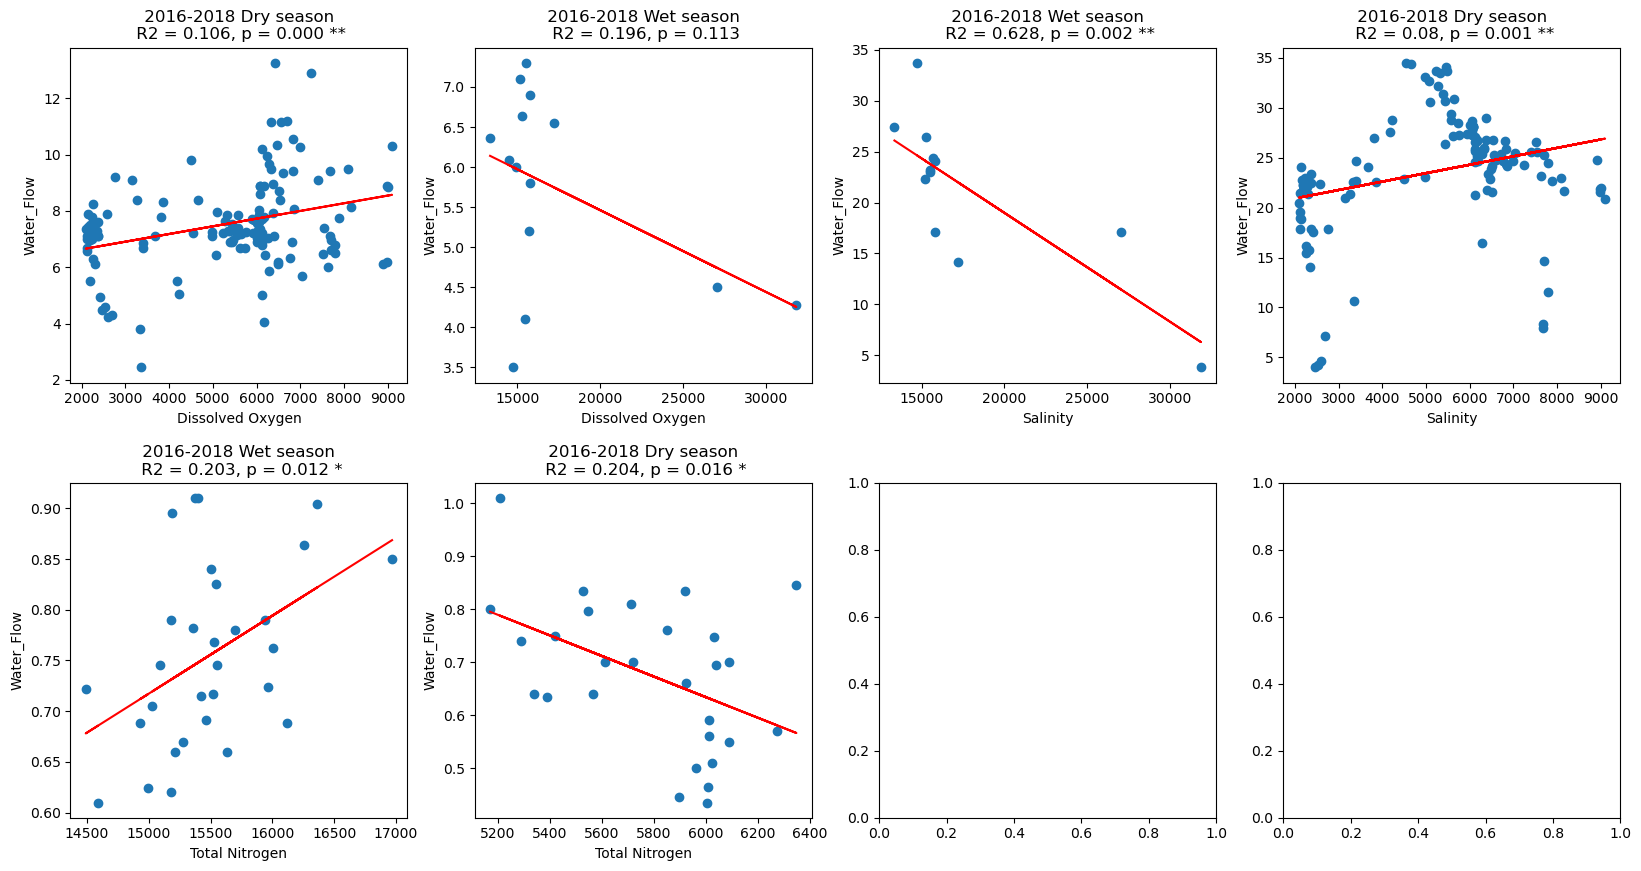

In [25]:
misc.covariateCopy.plot_regression(combined_waterflow_outputs[combined_waterflow_outputs['Area'] == 'Charlotte_Harbor'])

## 4.2 Estero_Bay <a class="anchor" id="reg_result_eb"></a>
### 4.2.1 Water Quality  <a class="anchor" id="reg_result_eb_wd"></a>

In [26]:
results_WD[results_WD['Area'] == 'Estero_Bay']

Dependent  Independent        Area       Year Season  Coefficient  \
3   Dissolved Oxygen  Water_Depth  Estero_Bay  2016-2018    Dry    -0.071590   
8   Dissolved Oxygen  Water_Depth  Estero_Bay  2016-2018    Wet    -0.041062   
13          Salinity  Water_Depth  Estero_Bay  2016-2018    Dry    -0.731509   
18          Salinity  Water_Depth  Estero_Bay  2016-2018    Wet    -1.368686   
23    Total Nitrogen  Water_Depth  Estero_Bay  2016-2018    Dry     0.002739   
28    Total Nitrogen  Water_Depth  Estero_Bay  2016-2018    Wet     0.004353   

    R-squared  p-value  
3    0.035286    0.107  
8    0.015427    0.400  
13   0.268813  0.027 *  
18   0.492746  0.016 *  
23   0.003590    0.649  
28   0.025995    0.320

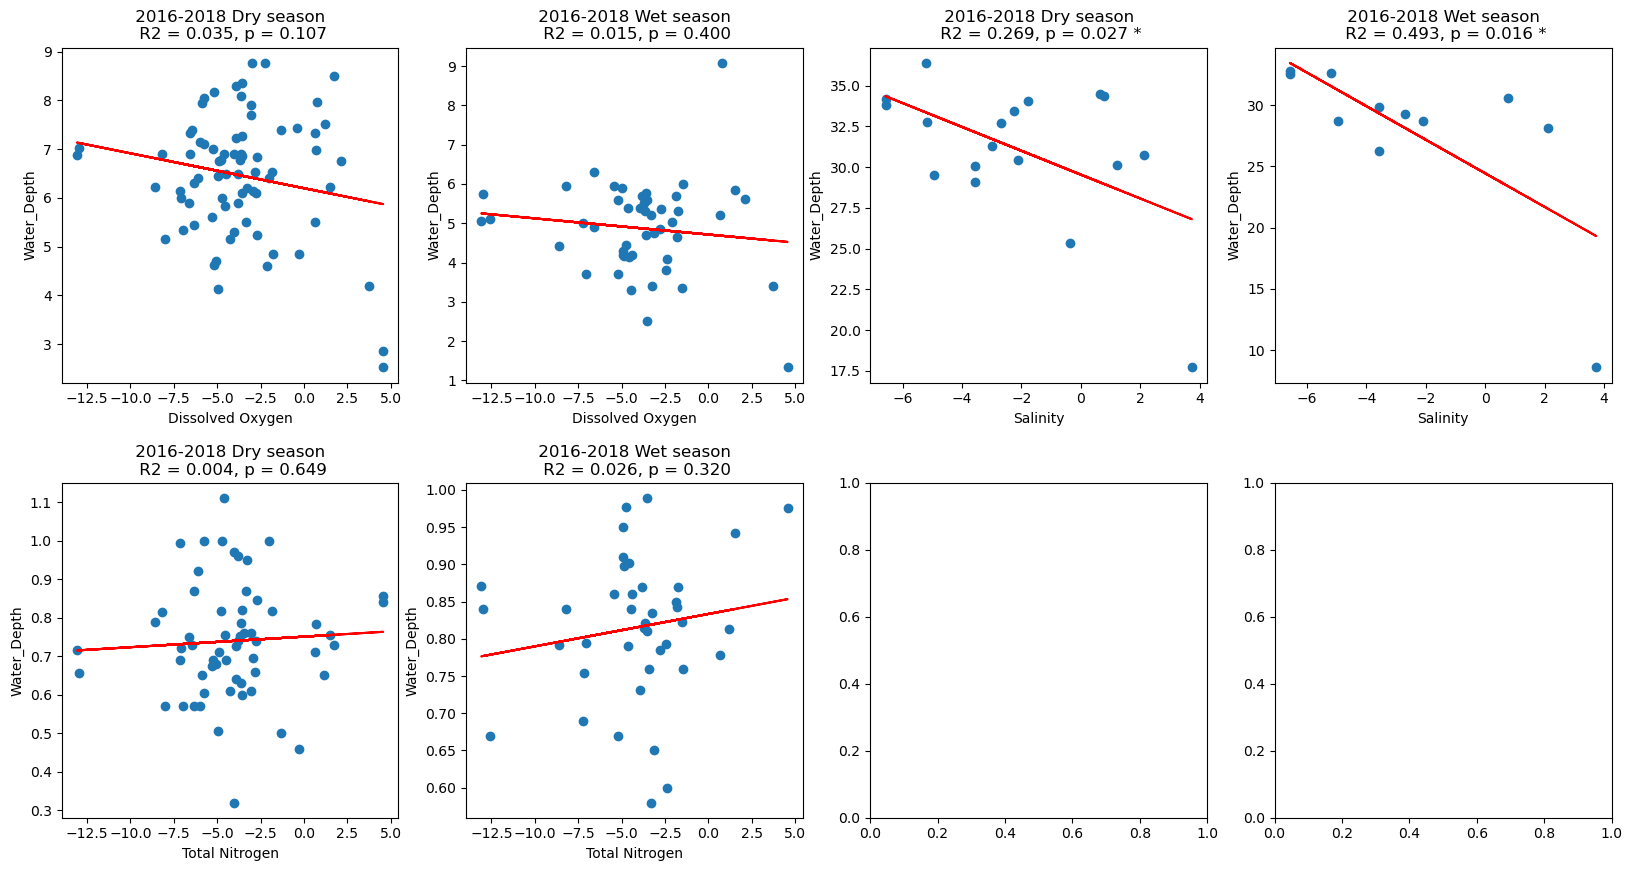

In [27]:
misc.covariateCopy.plot_regression(outputs_WD[outputs_WD['Area'] == 'Estero_Bay'])

### 4.2.2 Land development index (LDI_HUC_LSS)  <a class="anchor" id="reg_result_eb_ldi"></a>

In [28]:
results_LDI_HUC_LSS[results_LDI_HUC_LSS['Area'] == 'Estero_Bay']

Dependent  Independent        Area       Year Season  Coefficient  \
3   Dissolved Oxygen  LDI_HUC_LSS  Estero_Bay  2016-2018    Dry    -0.189719   
8   Dissolved Oxygen  LDI_HUC_LSS  Estero_Bay  2016-2018    Wet    -0.293748   
13          Salinity  LDI_HUC_LSS  Estero_Bay  2016-2018    Dry    -0.694719   
18          Salinity  LDI_HUC_LSS  Estero_Bay  2016-2018    Wet    -1.852206   
23    Total Nitrogen  LDI_HUC_LSS  Estero_Bay  2016-2018    Dry    -0.000177   
28    Total Nitrogen  LDI_HUC_LSS  Estero_Bay  2016-2018    Wet     0.005768   

    R-squared   p-value  
3    0.082101   0.013 *  
8    0.299702  0.000 **  
13   0.115978     0.167  
18   0.379563   0.044 *  
23   0.000006     0.985  
28   0.020430     0.379

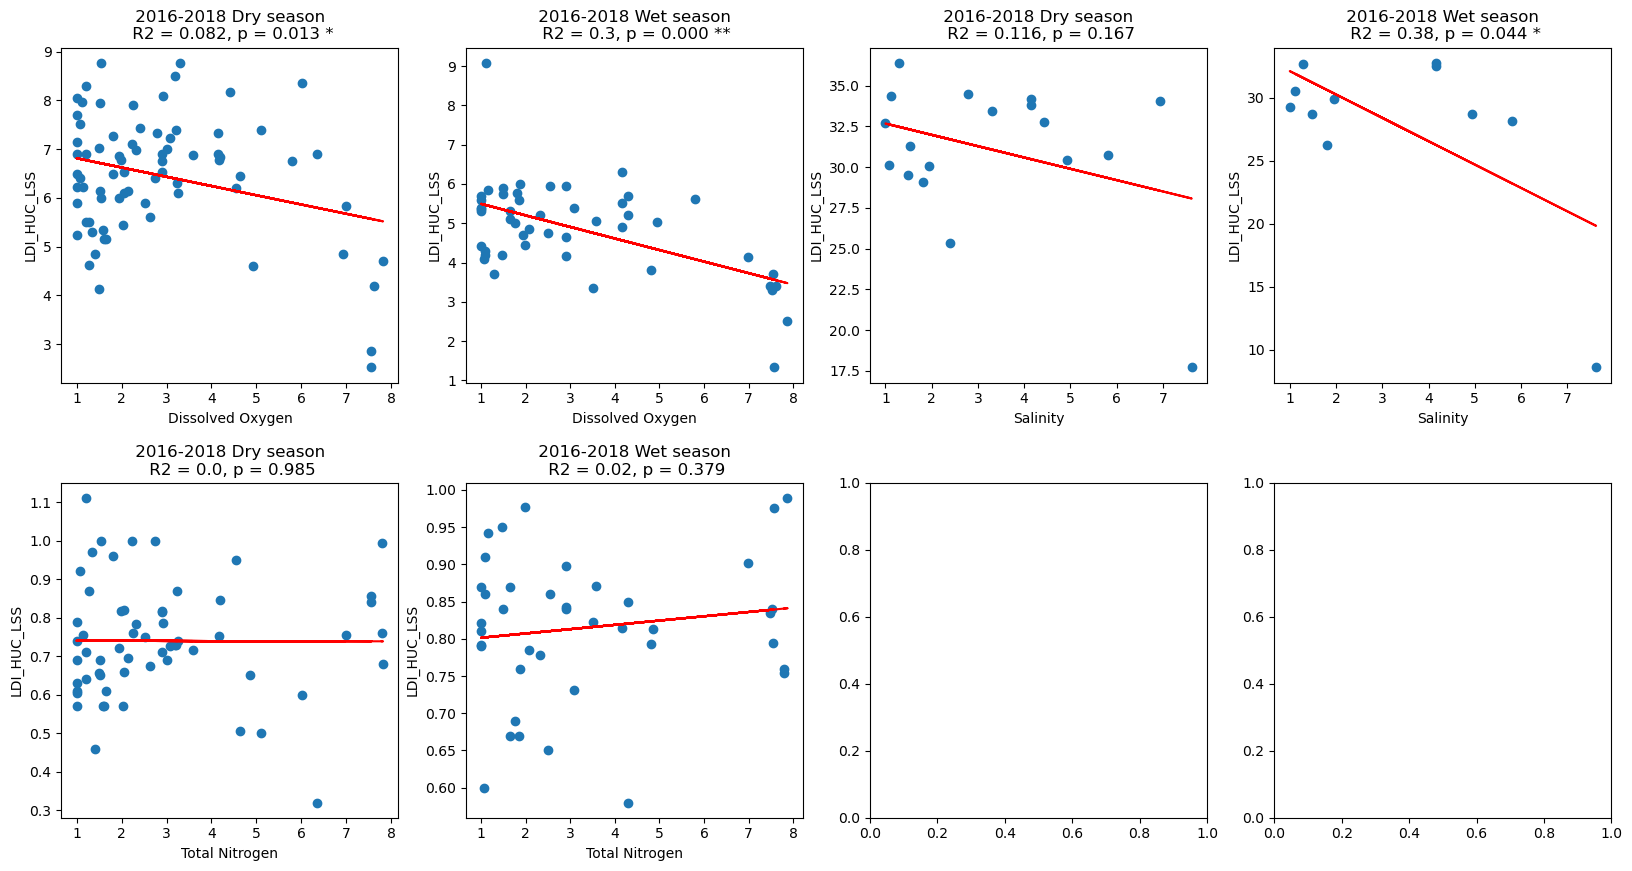

In [29]:
misc.covariateCopy.plot_regression(outputs_LDI_HUC_LSS[outputs_LDI_HUC_LSS['Area'] == 'Estero_Bay'])

### 4.2.3 Land development index (New_LDI_HUC_LSS)  <a class="anchor" id="reg_result_eb_new_ldi"></a>

In [30]:
results_New_LDI_HUC_LSS[results_New_LDI_HUC_LSS['Area'] == 'Estero_Bay']

Dependent      Independent        Area       Year Season  \
3   Dissolved Oxygen  New_LDI_HUC_LSS  Estero_Bay  2016-2018    Dry   
8   Dissolved Oxygen  New_LDI_HUC_LSS  Estero_Bay  2016-2018    Wet   
13          Salinity  New_LDI_HUC_LSS  Estero_Bay  2016-2018    Dry   
18          Salinity  New_LDI_HUC_LSS  Estero_Bay  2016-2018    Wet   
23    Total Nitrogen  New_LDI_HUC_LSS  Estero_Bay  2016-2018    Dry   
28    Total Nitrogen  New_LDI_HUC_LSS  Estero_Bay  2016-2018    Wet   

    Coefficient  R-squared   p-value  
3     -0.189389   0.082424   0.013 *  
8     -0.293830   0.300955  0.000 **  
13    -0.669993   0.110234     0.178  
18    -1.818979   0.372480   0.046 *  
23    -0.000242   0.000011     0.980  
28     0.005679   0.019809     0.386

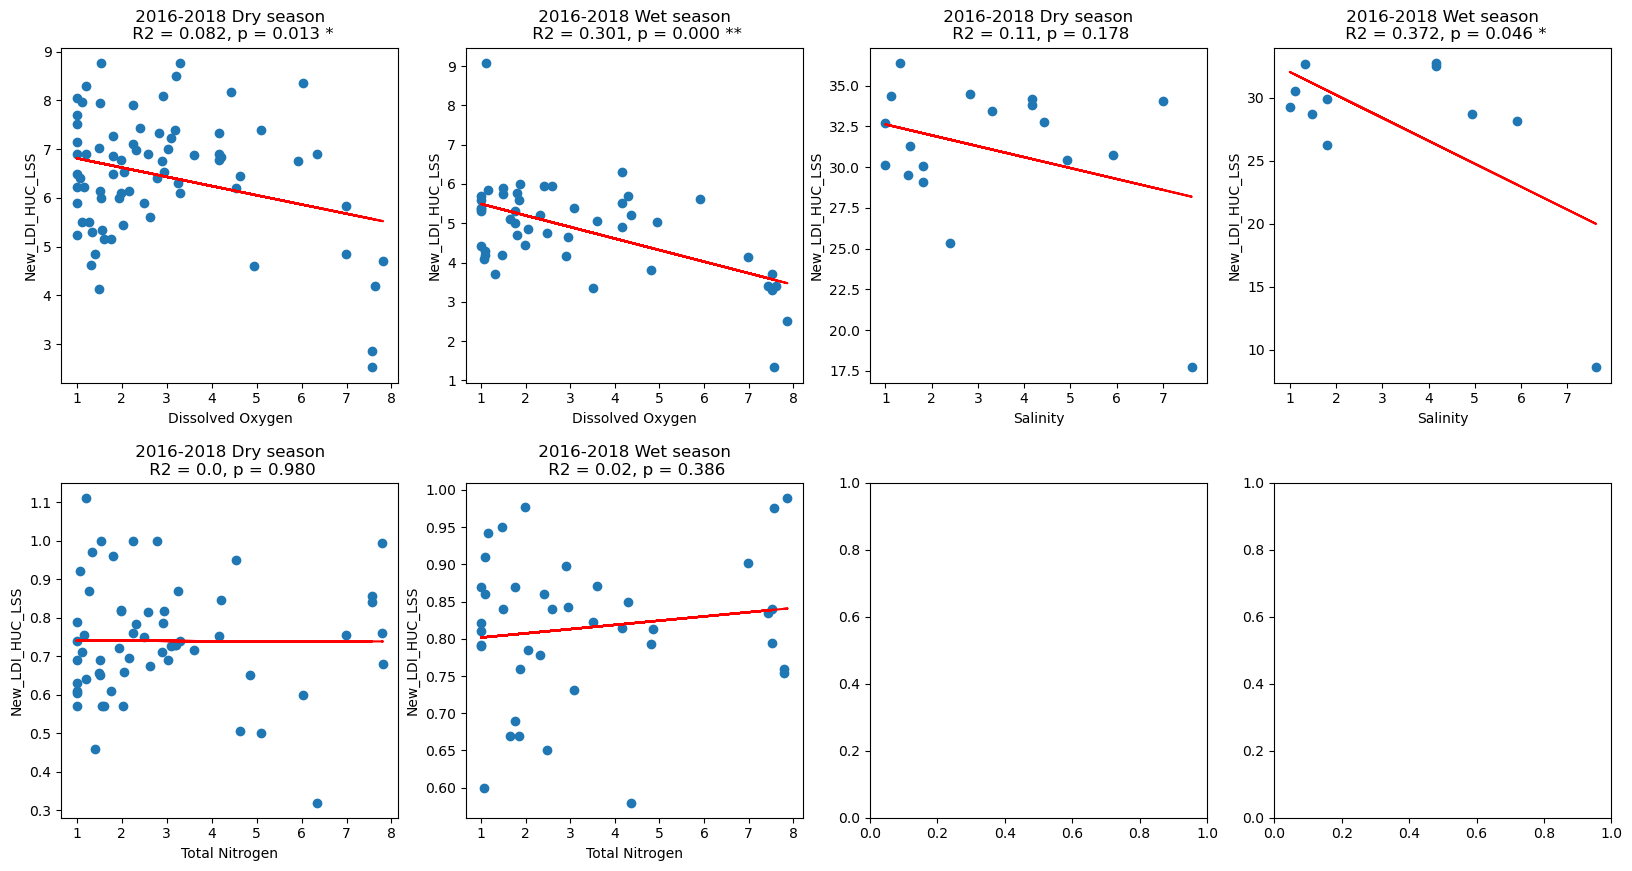

In [31]:
misc.covariateCopy.plot_regression(outputs_New_LDI_HUC_LSS[outputs_New_LDI_HUC_LSS['Area'] == 'Estero_Bay'])

### 4.2.4 Population Density (PopDen)  <a class="anchor" id="reg_result_eb_popden"></a>

In [32]:
results_PopDen[results_PopDen['Area'] == 'Estero_Bay']

Dependent Independent        Area       Year Season  Coefficient  \
3   Dissolved Oxygen      PopDen  Estero_Bay  2016-2018    Dry     0.000167   
8   Dissolved Oxygen      PopDen  Estero_Bay  2016-2018    Wet     0.000260   
13          Salinity      PopDen  Estero_Bay  2016-2018    Dry    -0.001378   
18          Salinity      PopDen  Estero_Bay  2016-2018    Wet    -0.004720   
23    Total Nitrogen      PopDen  Estero_Bay  2016-2018    Dry     0.000012   
28    Total Nitrogen      PopDen  Estero_Bay  2016-2018    Wet     0.000070   

    R-squared p-value  
3    0.002689   0.659  
8    0.006494   0.586  
13   0.027856   0.508  
18   0.145638   0.247  
23   0.000686   0.843  
28   0.033059   0.261

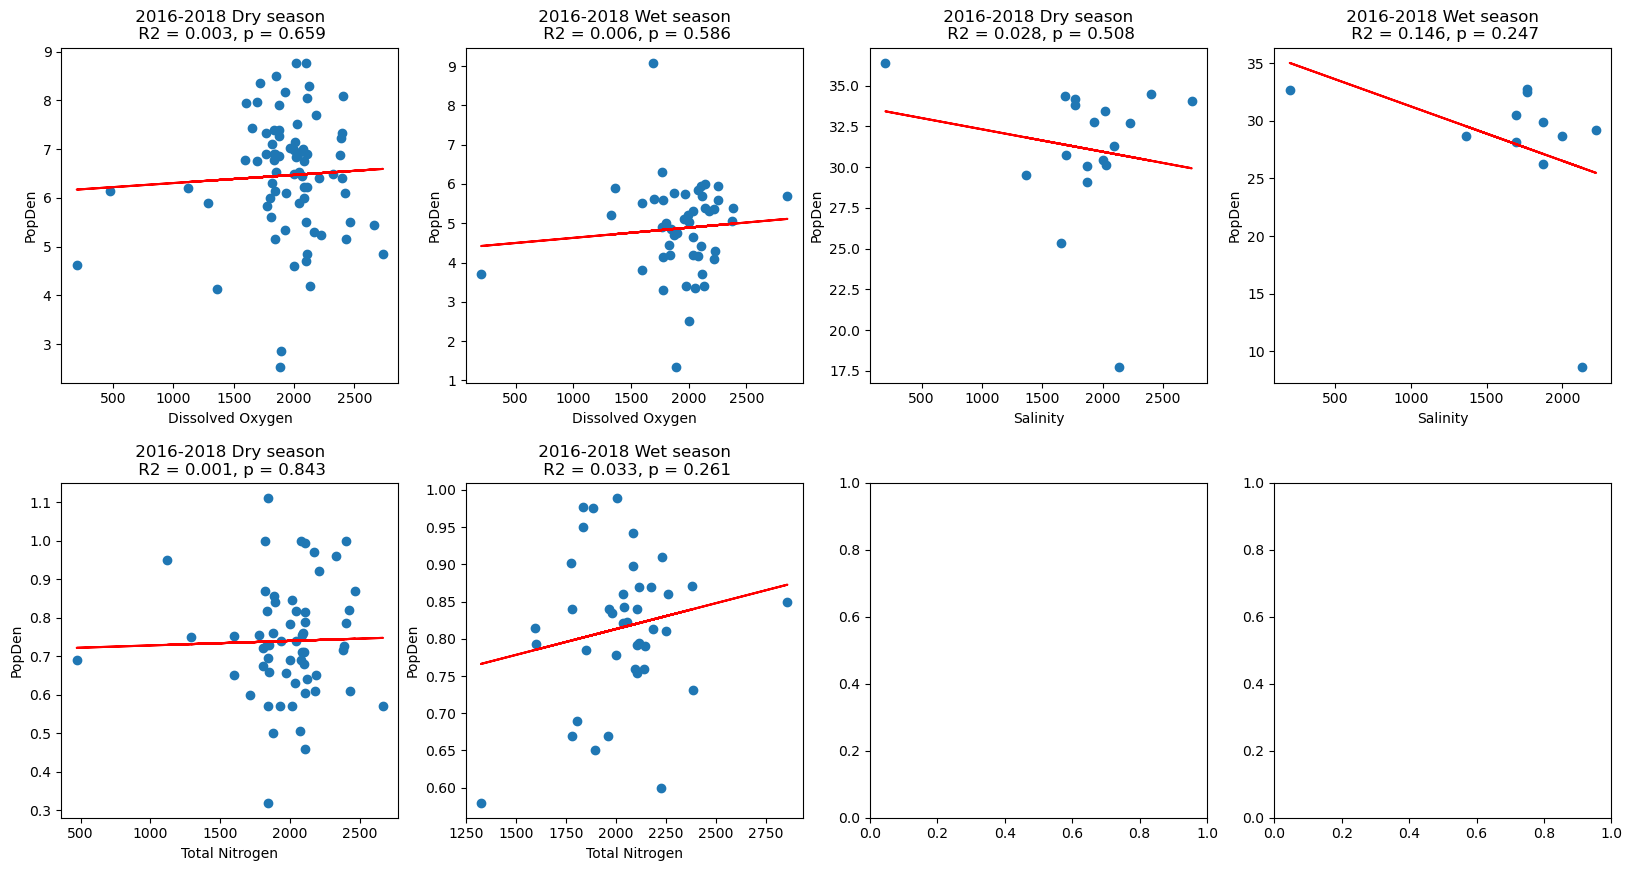

In [33]:
misc.covariateCopy.plot_regression(outputs_PopDen[outputs_PopDen['Area'] == 'Estero_Bay'])

### 4.2.5 Water Flow (combined_waterflow_results)  <a class="anchor" id="reg_result_eb_wf"></a>

In [34]:
combined_waterflow_results[combined_waterflow_results['Area'] == 'Estero_Bay']

Dependent Independent        Area       Year Season  Coefficient  \
3   Dissolved Oxygen  Water_Flow  Estero_Bay  2016-2018    Dry    -0.000279   
6   Dissolved Oxygen  Water_Flow  Estero_Bay  2016-2018    Wet     0.000369   
11          Salinity  Water_Flow  Estero_Bay  2016-2018    Wet     0.000255   
16          Salinity  Water_Flow  Estero_Bay  2016-2018    Dry     0.000873   
24    Total Nitrogen  Water_Flow  Estero_Bay  2016-2018    Dry     0.000049   
28    Total Nitrogen  Water_Flow  Estero_Bay  2016-2018    Wet    -0.000040   

    R-squared p-value  
3    0.016362   0.274  
6    0.029729   0.241  
11   0.000339   0.957  
16   0.025725   0.525  
24   0.025567   0.222  
28   0.059539   0.129

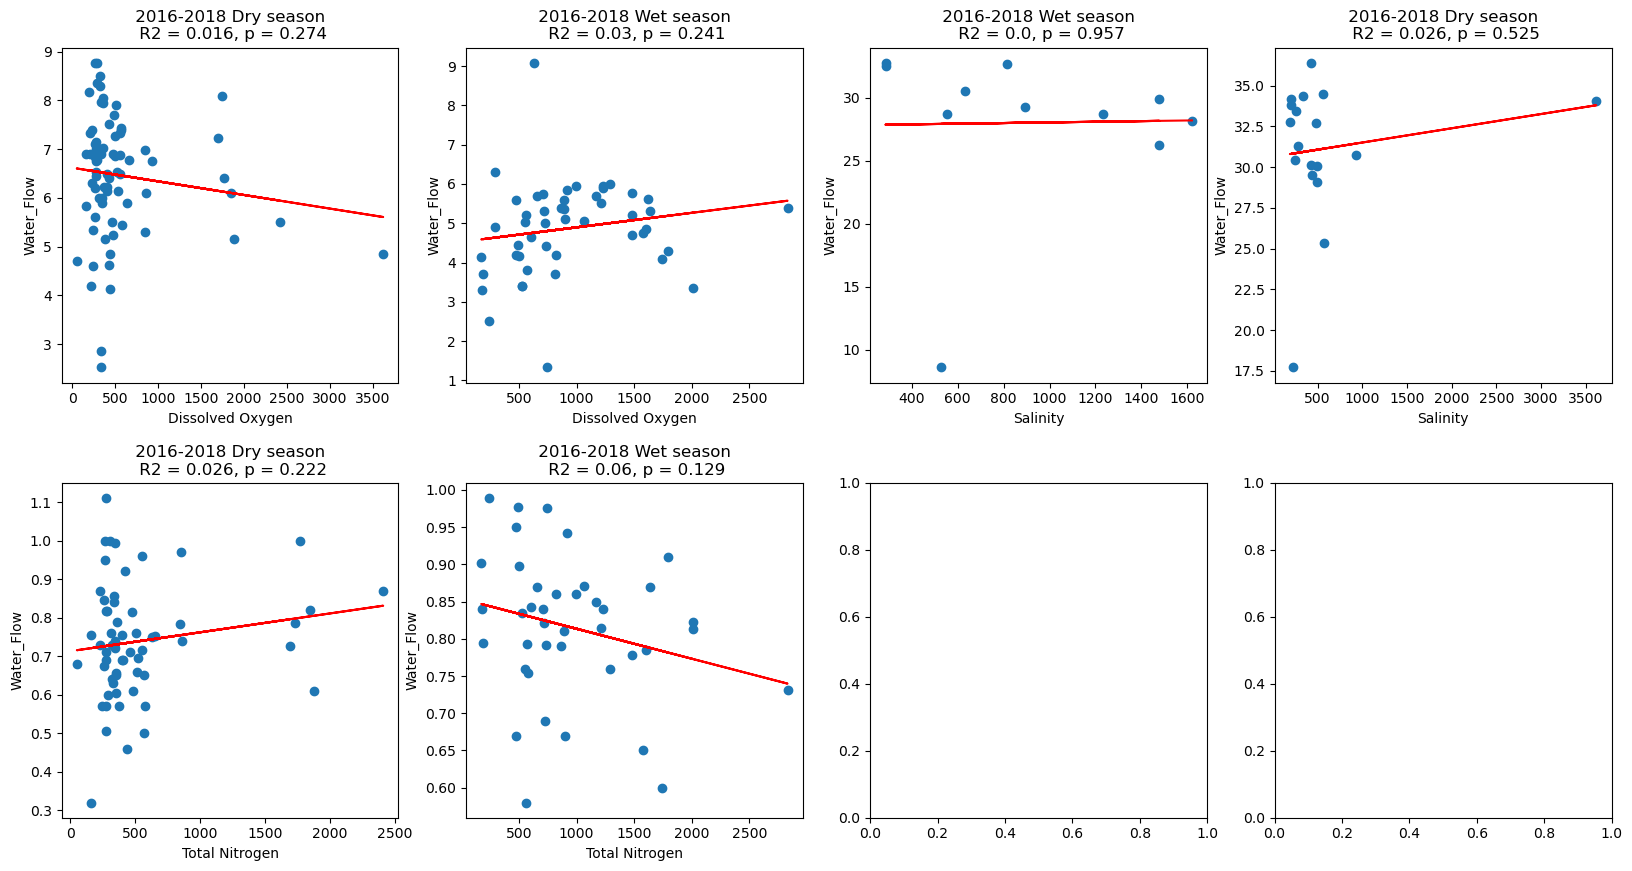

In [35]:
misc.covariateCopy.plot_regression(combined_waterflow_outputs[combined_waterflow_outputs['Area'] == 'Estero_Bay'])

## 4.3 Big Bend  <a class="anchor" id="reg_result_bb"></a>
### 4.3.1 Water Depth  <a class="anchor" id="reg_result_bb_wd"></a>

In [70]:
results_WD[results_WD['Area'] == 'Big_Bend']

Dependent  Independent      Area       Year Season  Coefficient  \
0   Dissolved Oxygen  Water_Depth  Big_Bend  2016-2018    Dry    -0.023260   
5   Dissolved Oxygen  Water_Depth  Big_Bend  2016-2018    Wet    -0.046008   
10          Salinity  Water_Depth  Big_Bend  2016-2018    Dry    -0.740479   
15          Salinity  Water_Depth  Big_Bend  2016-2018    Wet    -0.806762   
20    Total Nitrogen  Water_Depth  Big_Bend  2016-2018    Dry     0.008699   
25    Total Nitrogen  Water_Depth  Big_Bend  2016-2018    Wet     0.008394   

    R-squared   p-value  
0    0.009716     0.081  
5    0.060578   0.019 *  
10   0.159394  0.000 **  
15   0.358840  0.000 **  
20   0.034796     0.150  
25   0.017514     0.322

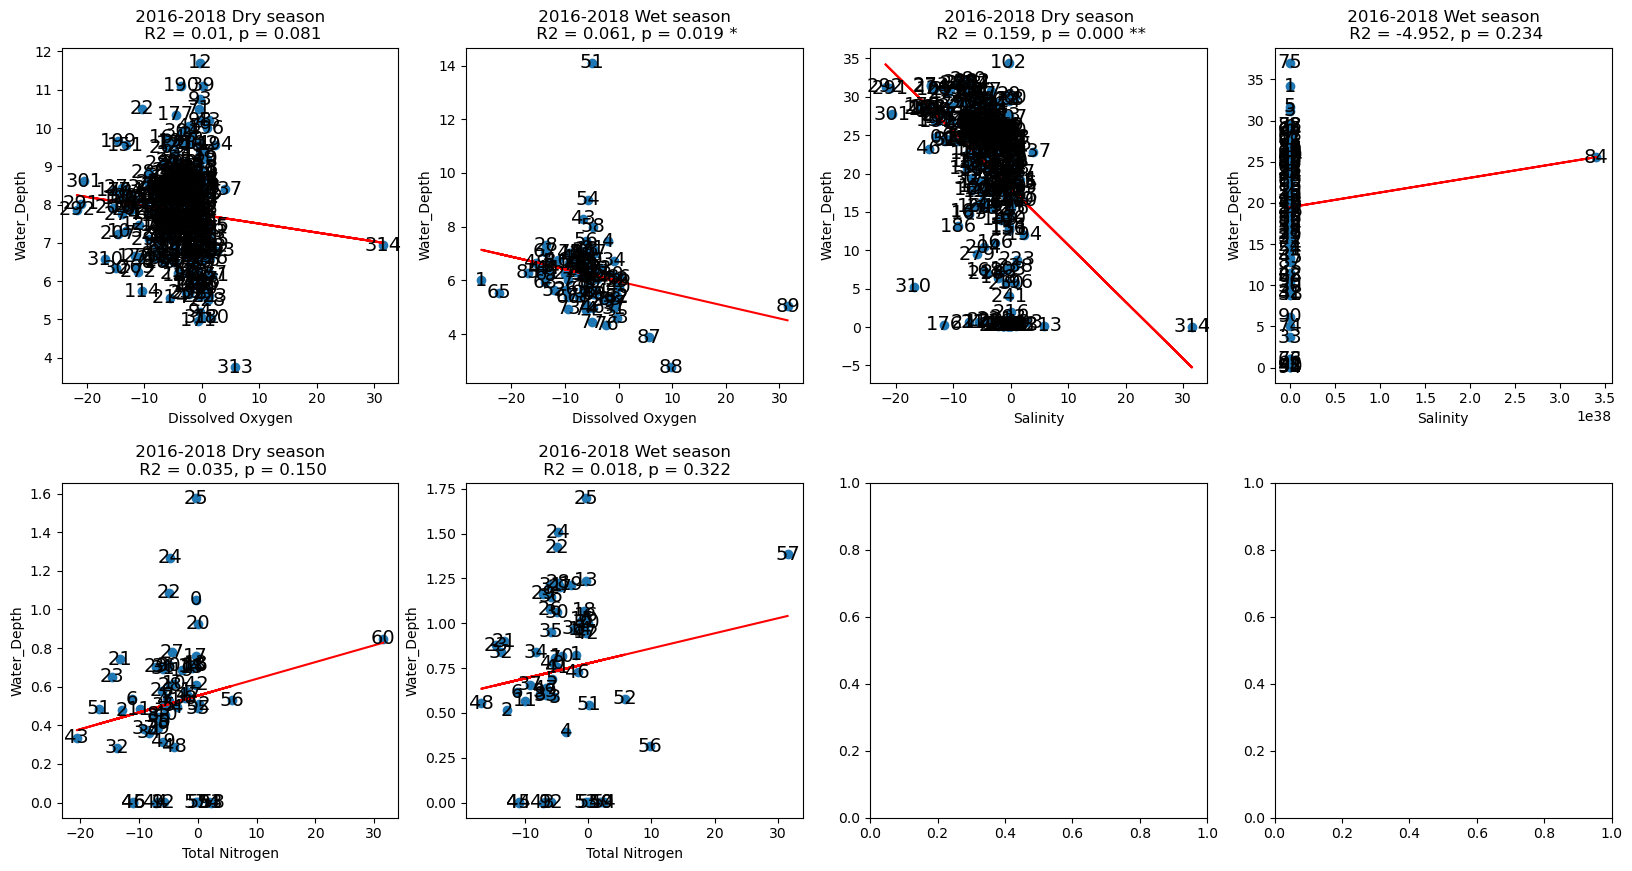

In [67]:
# Identify the outlier
misc.covariateCopy.plot_regression_index(outputs_WD[outputs_WD['Area'] == 'Big_Bend'])

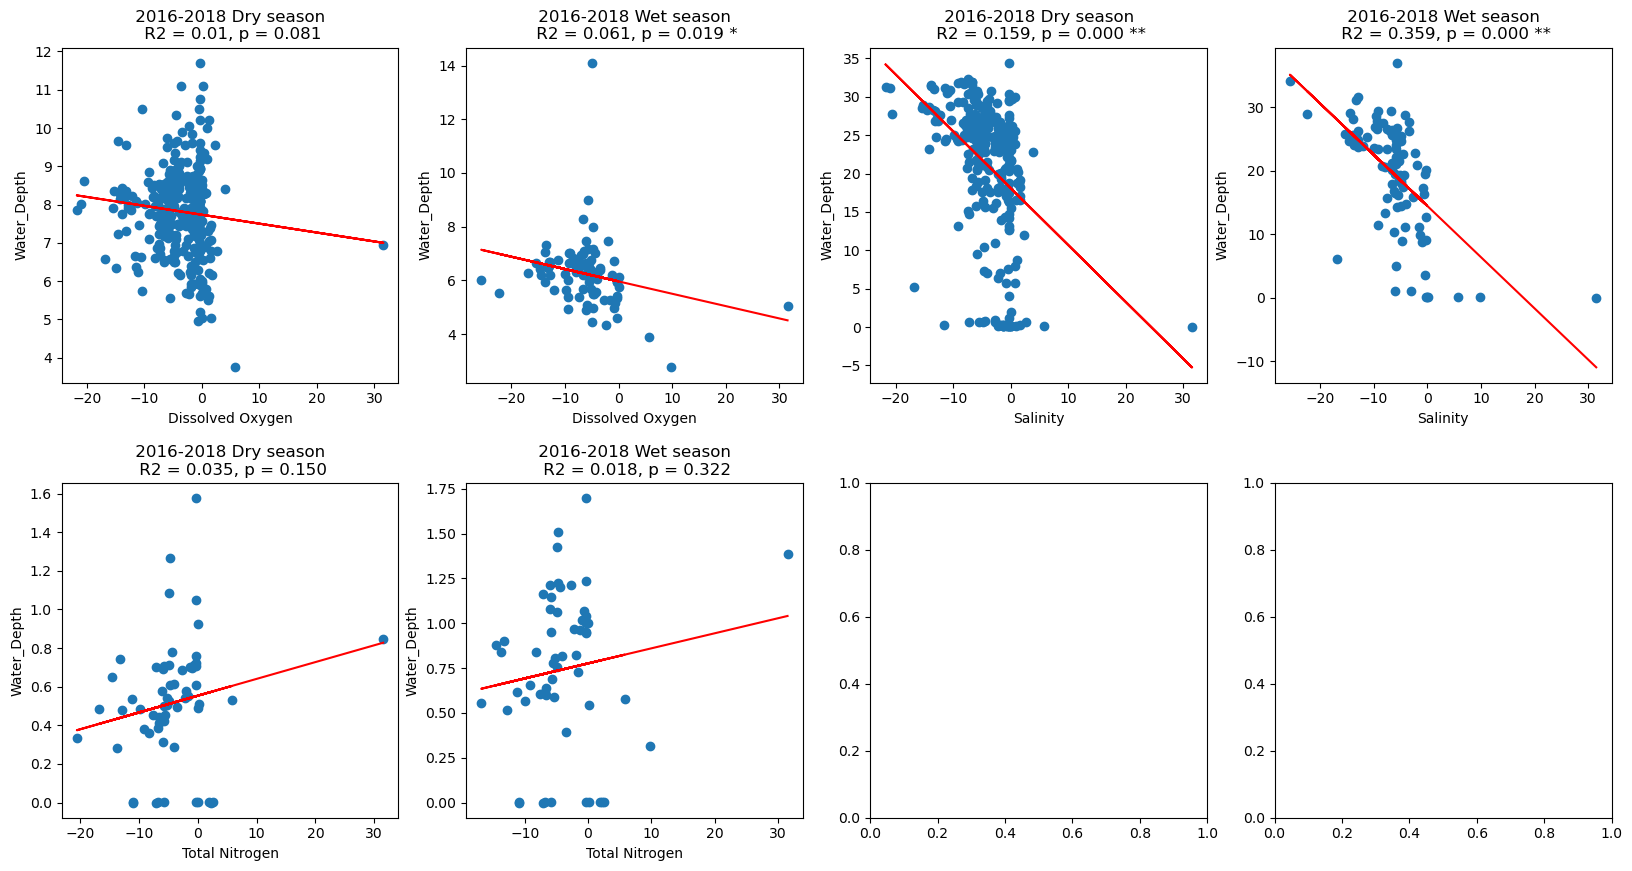

In [69]:
misc.covariateCopy.plot_regression(outputs_WD[outputs_WD['Area'] == 'Big_Bend'])

### 4.3.2 Land development index (LDI_HUC_LSS)  <a class="anchor" id="reg_result_bb_ldi"></a>

In [39]:
results_LDI_HUC_LSS[results_LDI_HUC_LSS['Area'] == 'Big_Bend']

Dependent  Independent      Area       Year Season  Coefficient  \
0   Dissolved Oxygen  LDI_HUC_LSS  Big_Bend  2016-2018    Dry    -0.148074   
5   Dissolved Oxygen  LDI_HUC_LSS  Big_Bend  2016-2018    Wet    -0.158683   
10          Salinity  LDI_HUC_LSS  Big_Bend  2016-2018    Dry    -2.816607   
15          Salinity  LDI_HUC_LSS  Big_Bend  2016-2018    Wet    -3.119593   
20    Total Nitrogen  LDI_HUC_LSS  Big_Bend  2016-2018    Dry     0.007071   
25    Total Nitrogen  LDI_HUC_LSS  Big_Bend  2016-2018    Wet    -0.004748   

    R-squared   p-value  
0    0.081179  0.000 **  
5    0.063582   0.017 *  
10   0.475453  0.000 **  
15   0.470466  0.000 **  
20   0.002216     0.719  
25   0.000525     0.864

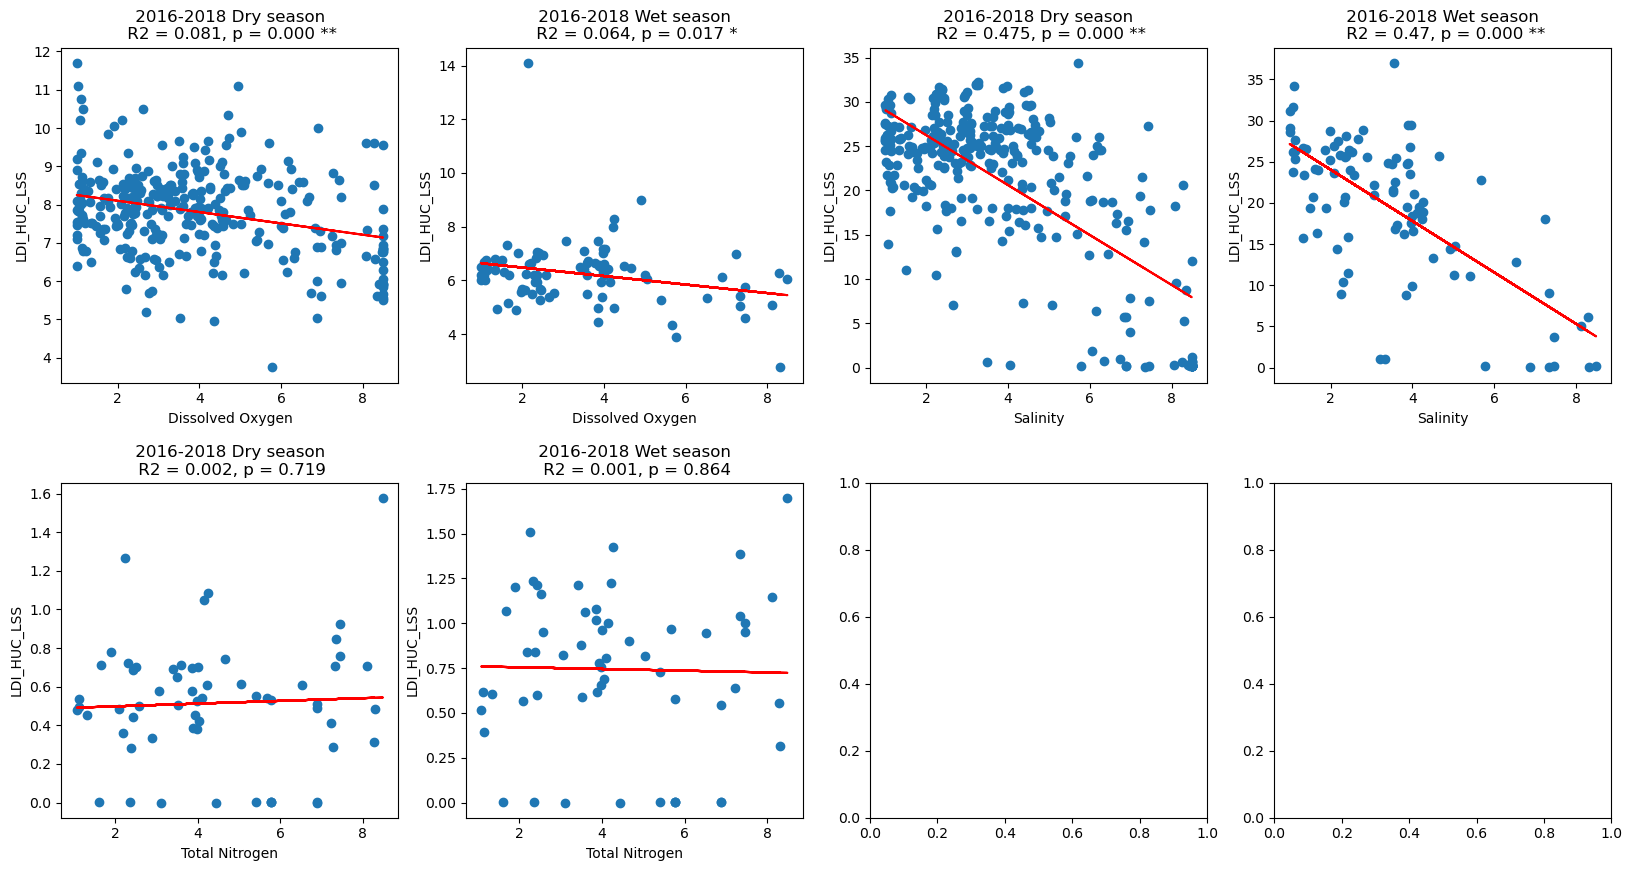

In [40]:
misc.covariateCopy.plot_regression(outputs_LDI_HUC_LSS[outputs_LDI_HUC_LSS['Area'] == 'Big_Bend'])

### 4.3.3 Land development index (New_LDI_HUC_LSS)  <a class="anchor" id="reg_result_bb_new_ldi"></a>

In [41]:
results_New_LDI_HUC_LSS[results_New_LDI_HUC_LSS['Area'] == 'Big_Bend']

Dependent      Independent      Area       Year Season  \
0   Dissolved Oxygen  New_LDI_HUC_LSS  Big_Bend  2016-2018    Dry   
5   Dissolved Oxygen  New_LDI_HUC_LSS  Big_Bend  2016-2018    Wet   
10          Salinity  New_LDI_HUC_LSS  Big_Bend  2016-2018    Dry   
15          Salinity  New_LDI_HUC_LSS  Big_Bend  2016-2018    Wet   
20    Total Nitrogen  New_LDI_HUC_LSS  Big_Bend  2016-2018    Dry   
25    Total Nitrogen  New_LDI_HUC_LSS  Big_Bend  2016-2018    Wet   

    Coefficient  R-squared   p-value  
0     -0.146969   0.080075  0.000 **  
5     -0.158803   0.063652   0.016 *  
10    -2.812096   0.474535  0.000 **  
15    -3.120510   0.470540  0.000 **  
20     0.007078   0.002221     0.718  
25    -0.004742   0.000524     0.865

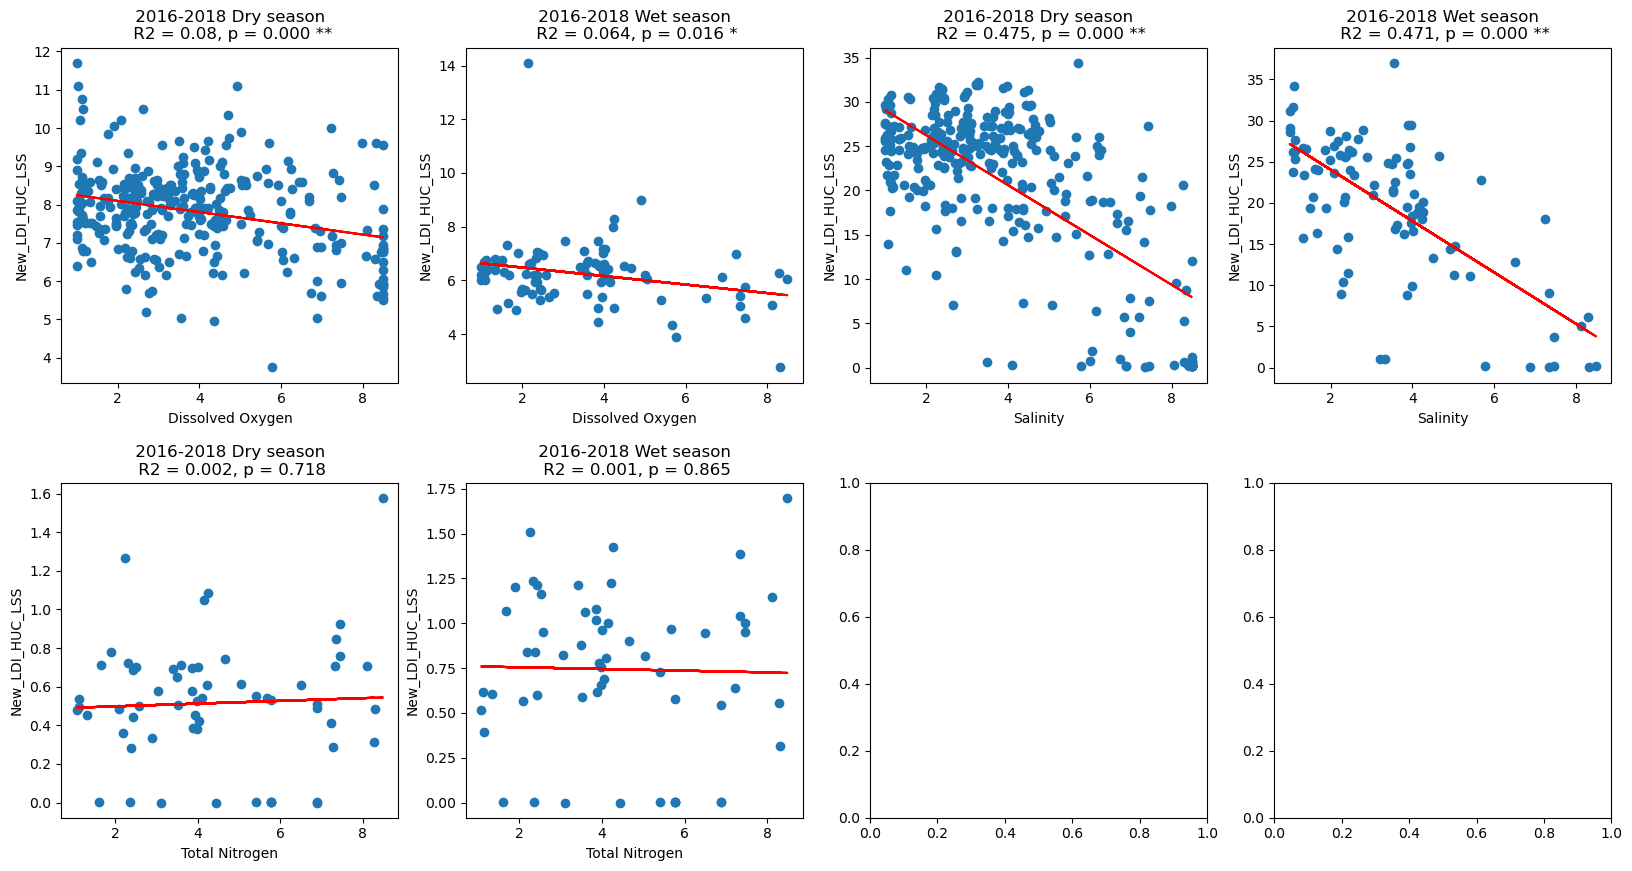

In [42]:
misc.covariateCopy.plot_regression(outputs_New_LDI_HUC_LSS[outputs_New_LDI_HUC_LSS['Area'] == 'Big_Bend'])

### 4.3.4 Population Density (PopDen)  <a class="anchor" id="reg_result_bb_popden"></a>

In [43]:
results_PopDen[results_PopDen['Area'] == 'Big_Bend']

Dependent Independent      Area       Year Season  Coefficient  \
0   Dissolved Oxygen      PopDen  Big_Bend  2016-2018    Dry     0.000598   
5   Dissolved Oxygen      PopDen  Big_Bend  2016-2018    Wet    -0.003190   
10          Salinity      PopDen  Big_Bend  2016-2018    Dry     0.016544   
15          Salinity      PopDen  Big_Bend  2016-2018    Wet    -0.058813   
20    Total Nitrogen      PopDen  Big_Bend  2016-2018    Dry    -0.001932   
25    Total Nitrogen      PopDen  Big_Bend  2016-2018    Wet    -0.003402   

    R-squared   p-value  
0    0.000607     0.663  
5    0.019781     0.186  
10   0.007507     0.125  
15   0.129912  0.000 **  
20   0.193020  0.000 **  
25   0.301837  0.000 **

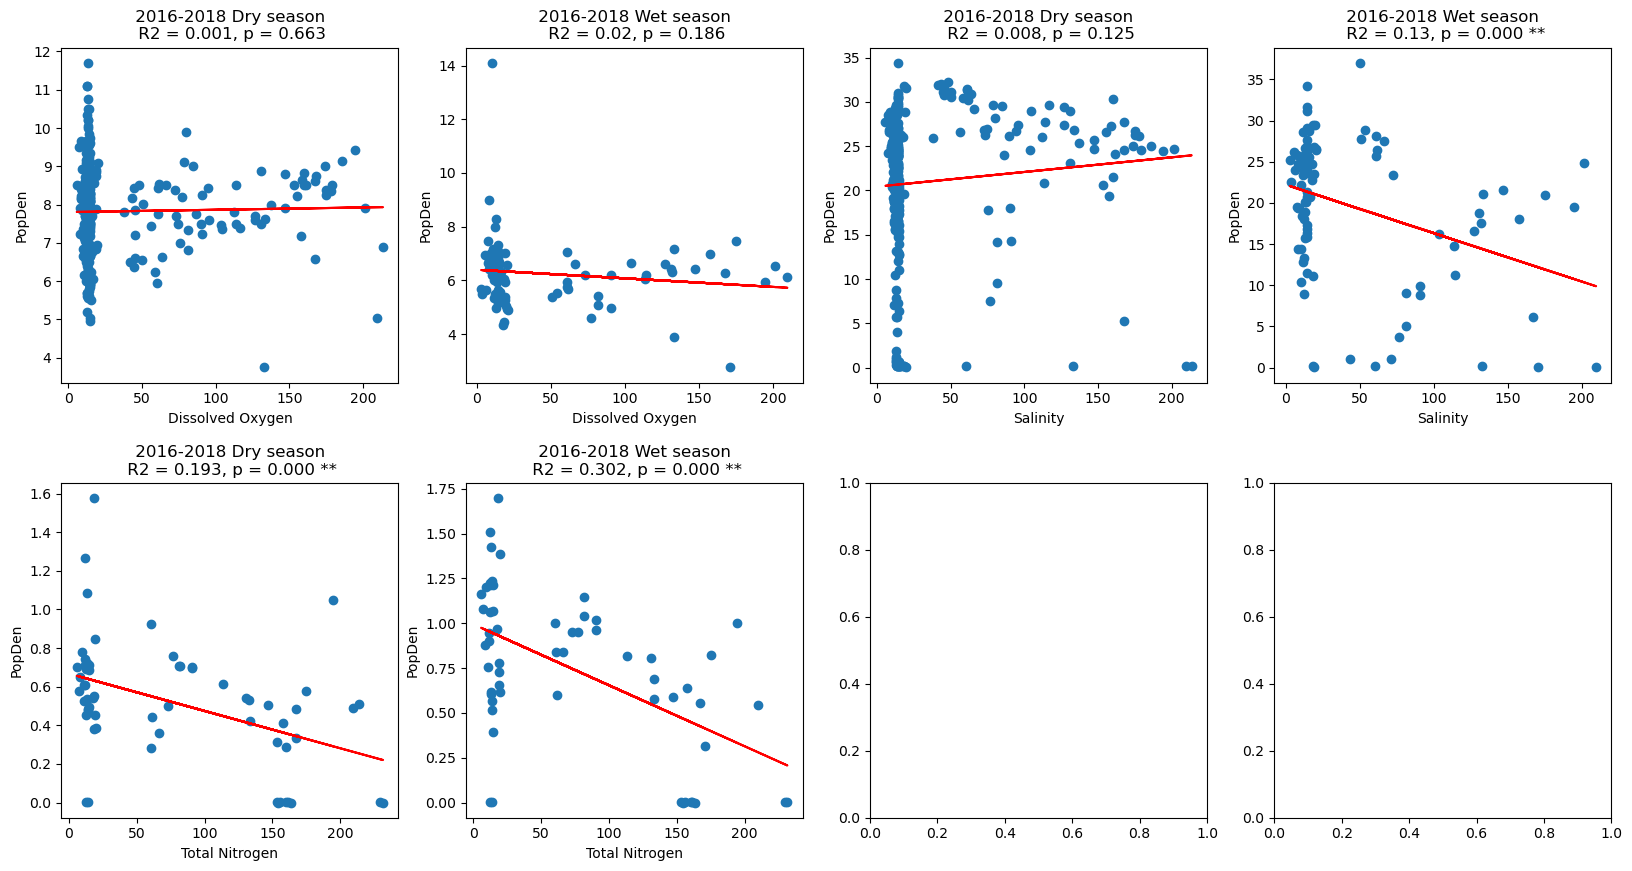

In [44]:
misc.covariateCopy.plot_regression(outputs_PopDen[outputs_PopDen['Area'] == 'Big_Bend'])

### 4.3.5 Water Flow (combined_waterflow_results)  <a class="anchor" id="reg_result_bb_wf"></a>

In [45]:
combined_waterflow_results[combined_waterflow_results['Area'] == 'Big_Bend']

Dependent Independent      Area       Year Season  Coefficient  \
0   Dissolved Oxygen  Water_Flow  Big_Bend  2016-2018    Dry    -0.000019   
9   Dissolved Oxygen  Water_Flow  Big_Bend  2016-2018    Wet     0.000097   
10          Salinity  Water_Flow  Big_Bend  2016-2018    Wet     0.000134   
19          Salinity  Water_Flow  Big_Bend  2016-2018    Dry    -0.000620   
21    Total Nitrogen  Water_Flow  Big_Bend  2016-2018    Wet     0.000045   
27    Total Nitrogen  Water_Flow  Big_Bend  2016-2018    Dry     0.000026   

    R-squared   p-value  
0    0.012885   0.044 *  
9    0.144122  0.000 **  
10   0.005615     0.470  
19   0.228588  0.000 **  
21   0.264003  0.000 **  
27   0.189967  0.000 **

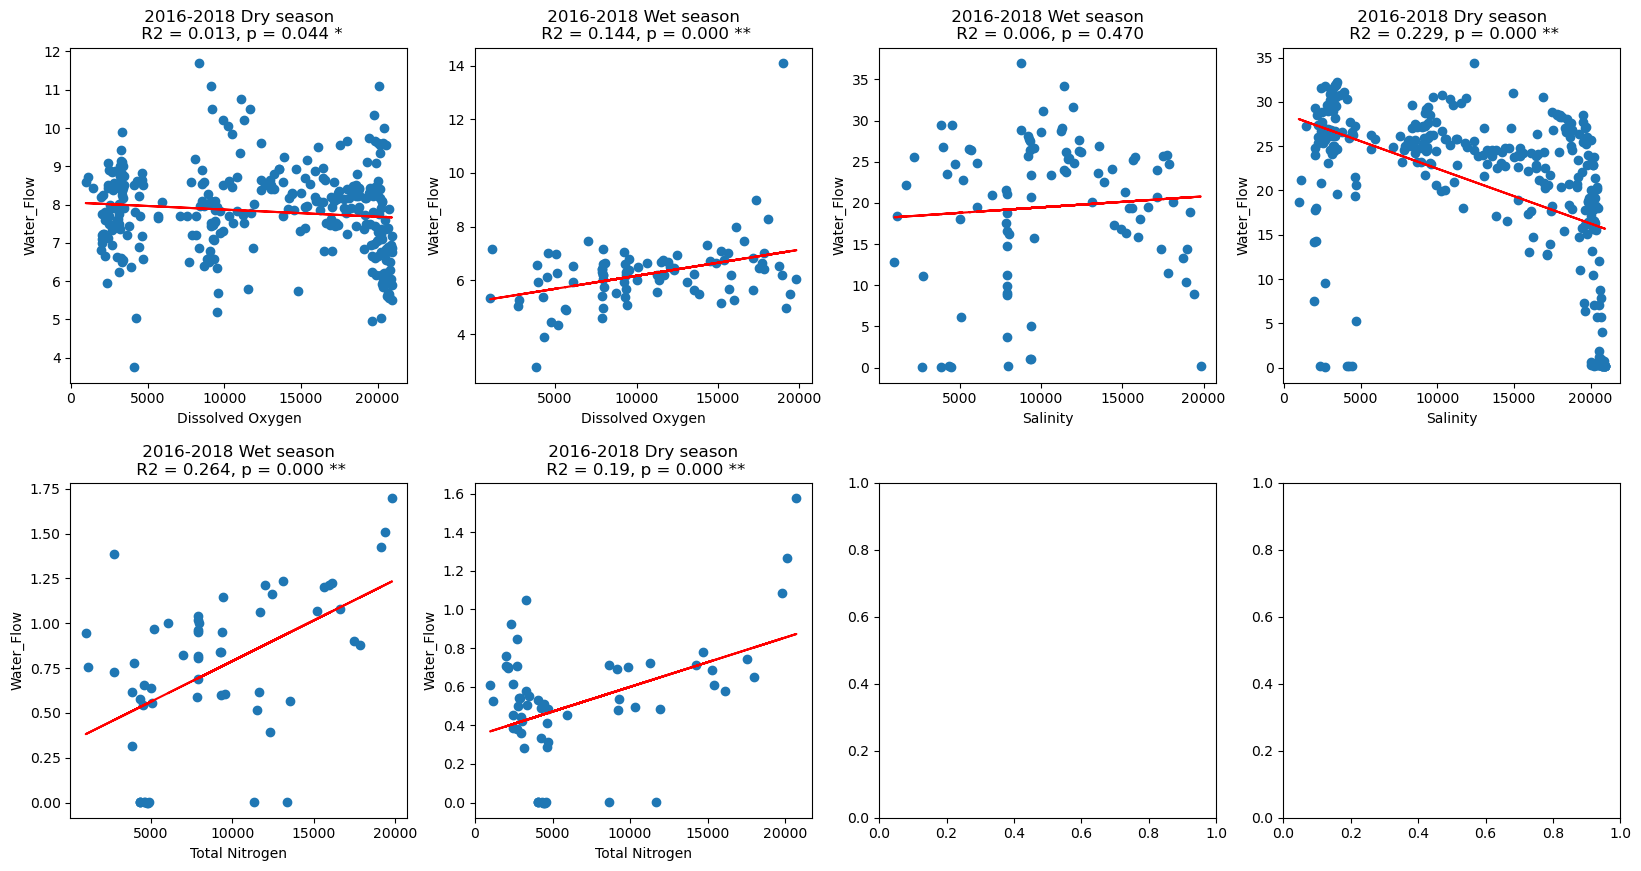

In [46]:
misc.covariateCopy.plot_regression(combined_waterflow_outputs[combined_waterflow_outputs['Area'] == 'Big_Bend'])

## 4.4 Biscayne Bay Aquatic Preserve  <a class="anchor" id="reg_result_bbap"></a>
### 4.4.1 Water Depth  <a class="anchor" id="reg_result_bbap_wd"></a>

In [47]:
results_WD[results_WD['Area'] == 'Biscayne_Bay']

Dependent  Independent          Area       Year Season  \
1   Dissolved Oxygen  Water_Depth  Biscayne_Bay  2016-2018    Dry   
6   Dissolved Oxygen  Water_Depth  Biscayne_Bay  2016-2018    Wet   
11          Salinity  Water_Depth  Biscayne_Bay  2016-2018    Dry   
16          Salinity  Water_Depth  Biscayne_Bay  2016-2018    Wet   
21    Total Nitrogen  Water_Depth  Biscayne_Bay  2016-2018    Dry   
26    Total Nitrogen  Water_Depth  Biscayne_Bay  2016-2018    Wet   

    Coefficient  R-squared  p-value  
1      0.022174   0.031892    0.220  
6      0.004889   0.004157    0.663  
11    -0.070691   0.075919    0.055  
16    -0.073312   0.074034    0.061  
21     0.002303   0.134178  0.020 *  
26     0.001387   0.018372    0.398

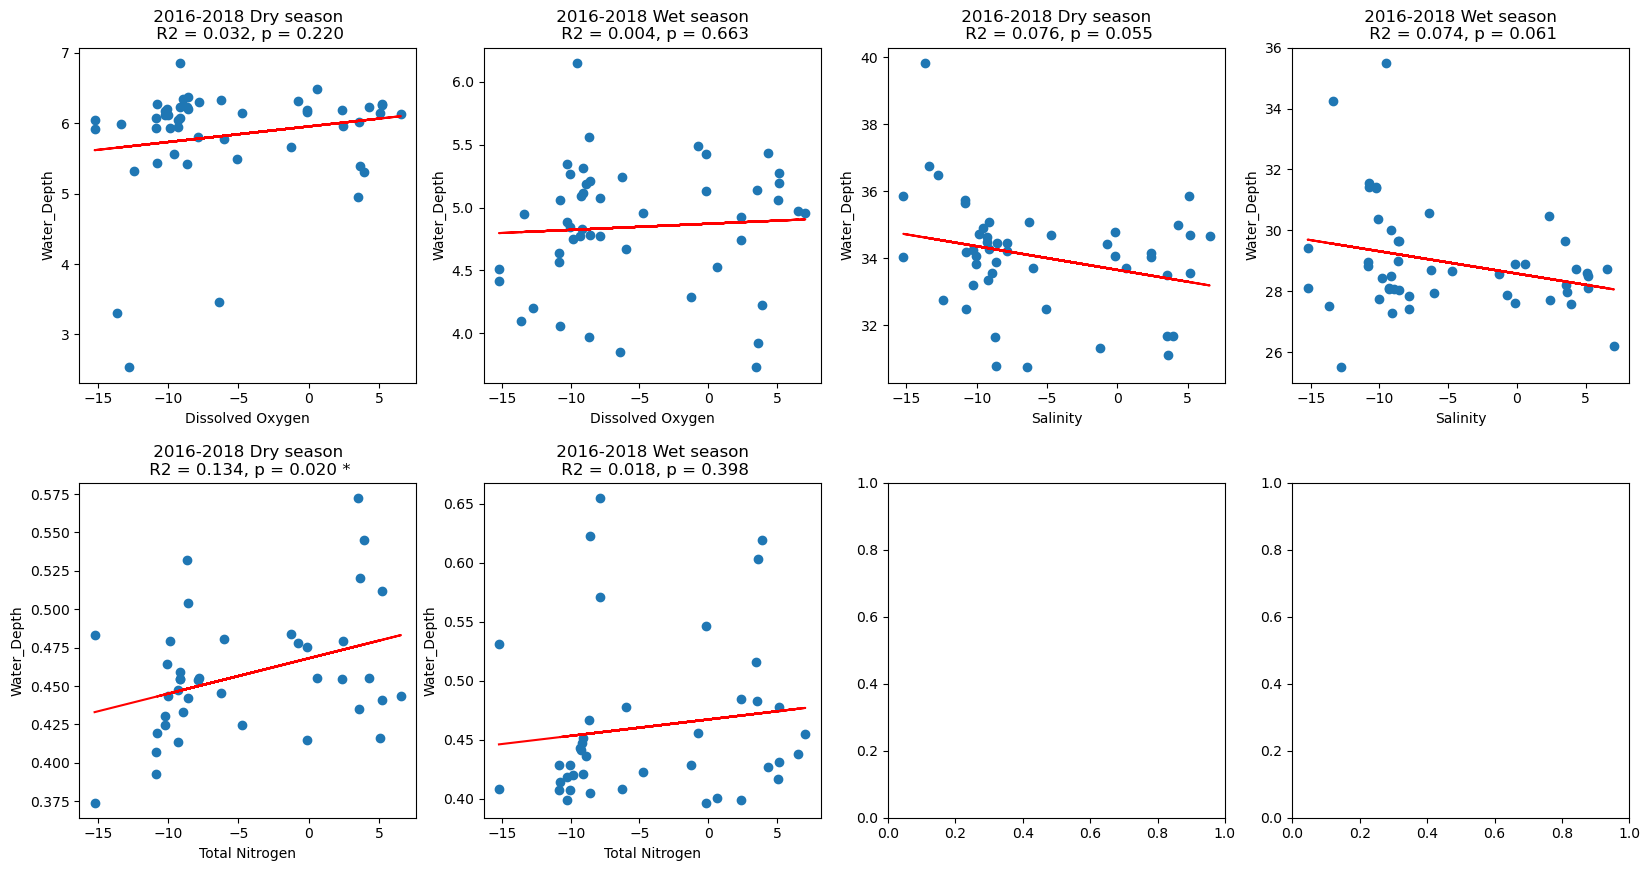

In [48]:
misc.covariateCopy.plot_regression(outputs_WD[outputs_WD['Area'] == 'Biscayne_Bay'])

### 4.4.2 Land development index (LDI_HUC_LSS)  <a class="anchor" id="reg_result_bbap_ldi"></a>

In [49]:
results_LDI_HUC_LSS[results_LDI_HUC_LSS['Area'] == 'Biscayne_Bay']

Dependent  Independent          Area       Year Season  \
1   Dissolved Oxygen  LDI_HUC_LSS  Biscayne_Bay  2016-2018    Dry   
6   Dissolved Oxygen  LDI_HUC_LSS  Biscayne_Bay  2016-2018    Wet   
11          Salinity  LDI_HUC_LSS  Biscayne_Bay  2016-2018    Dry   
16          Salinity  LDI_HUC_LSS  Biscayne_Bay  2016-2018    Wet   
21    Total Nitrogen  LDI_HUC_LSS  Biscayne_Bay  2016-2018    Dry   
26    Total Nitrogen  LDI_HUC_LSS  Biscayne_Bay  2016-2018    Wet   

    Coefficient  R-squared  p-value  
1      0.233608   0.095487  0.031 *  
6     -0.068472   0.019875    0.339  
11     0.080999   0.002689    0.723  
16    -0.431440   0.062488    0.087  
21    -0.021654   0.093750    0.055  
26    -0.026314   0.048711    0.166

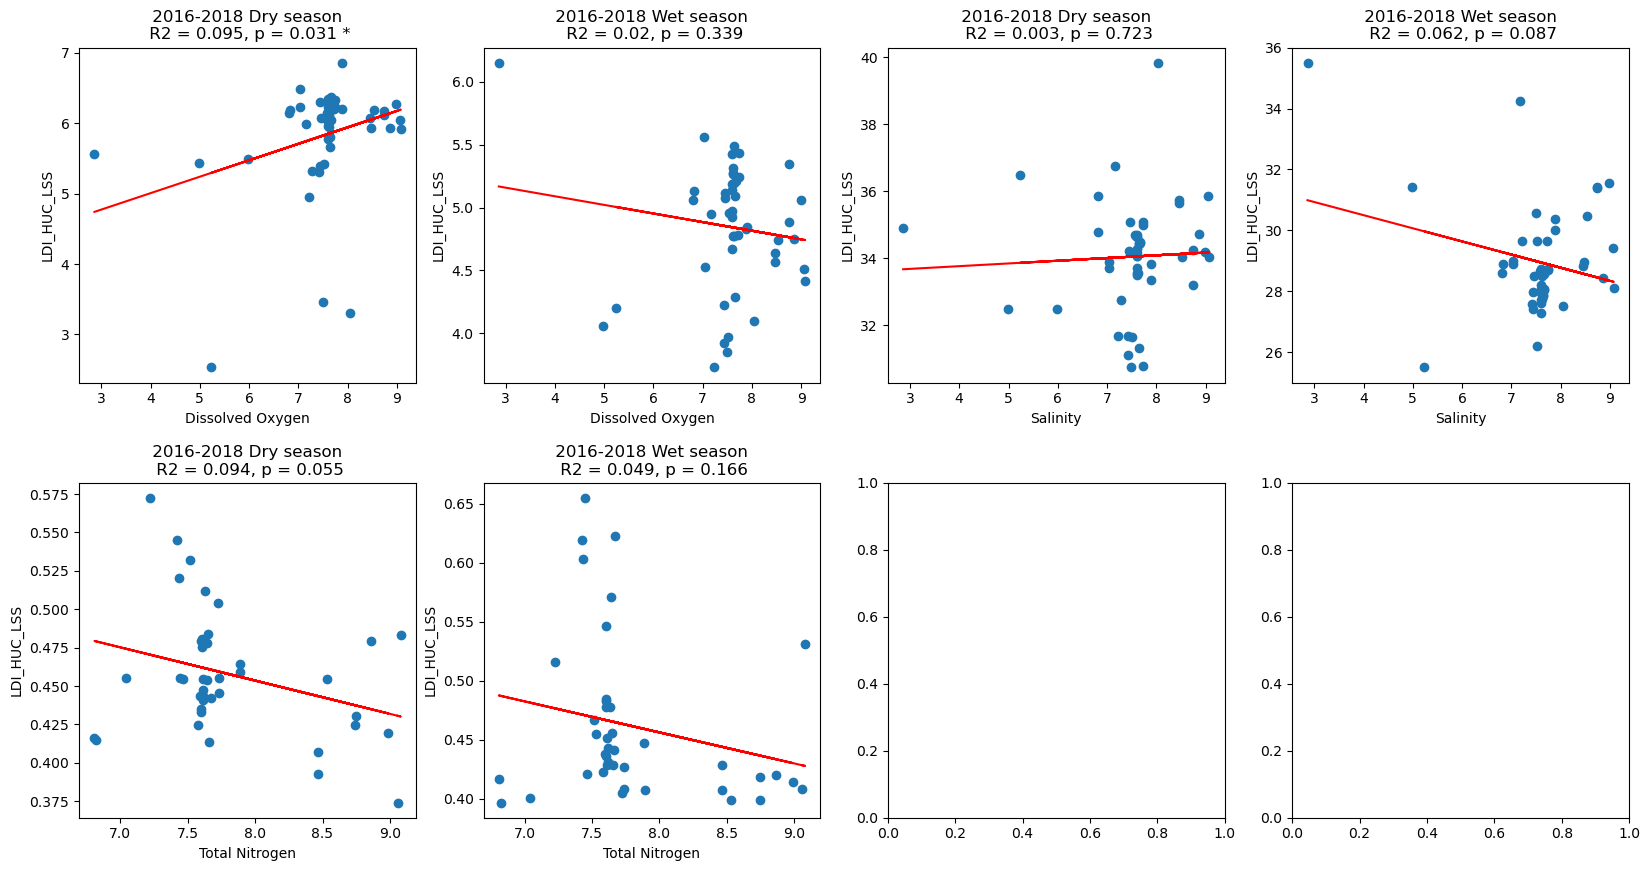

In [50]:
misc.covariateCopy.plot_regression(outputs_LDI_HUC_LSS[outputs_WD['Area'] == 'Biscayne_Bay'])

### 4.4.3 Land development index (New_LDI_HUC_LSS)  <a class="anchor" id="reg_result_bbap_new_ldi"></a>

In [51]:
results_New_LDI_HUC_LSS[results_New_LDI_HUC_LSS['Area'] == 'Biscayne_Bay']

Dependent      Independent          Area       Year Season  \
1   Dissolved Oxygen  New_LDI_HUC_LSS  Biscayne_Bay  2016-2018    Dry   
6   Dissolved Oxygen  New_LDI_HUC_LSS  Biscayne_Bay  2016-2018    Wet   
11          Salinity  New_LDI_HUC_LSS  Biscayne_Bay  2016-2018    Dry   
16          Salinity  New_LDI_HUC_LSS  Biscayne_Bay  2016-2018    Wet   
21    Total Nitrogen  New_LDI_HUC_LSS  Biscayne_Bay  2016-2018    Dry   
26    Total Nitrogen  New_LDI_HUC_LSS  Biscayne_Bay  2016-2018    Wet   

    Coefficient  R-squared  p-value  
1      0.233893   0.095789  0.030 *  
6     -0.067621   0.019396    0.345  
11     0.081697   0.002737    0.721  
16    -0.430288   0.062192    0.087  
21    -0.021717   0.094867    0.053  
26    -0.026571   0.049965    0.160

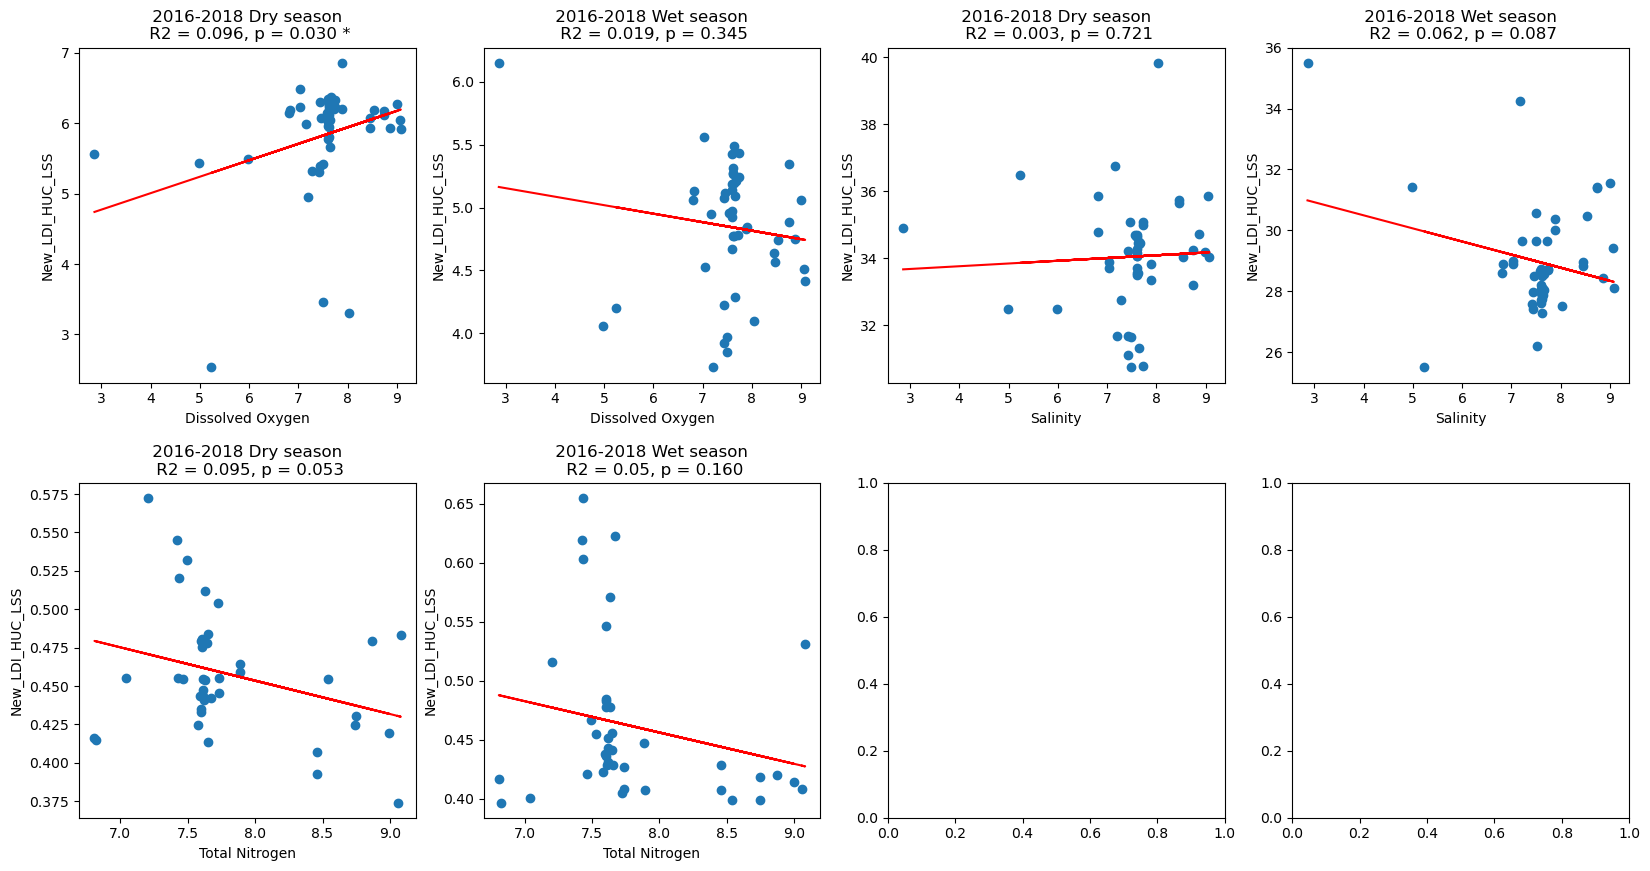

In [52]:
misc.covariateCopy.plot_regression(outputs_New_LDI_HUC_LSS[outputs_New_LDI_HUC_LSS['Area'] == 'Biscayne_Bay'])

### 4.4.4 Population Density (PopDen)  <a class="anchor" id="reg_result_bbap_popden"></a>

In [53]:
results_PopDen[results_PopDen['Area'] == 'Biscayne_Bay']

Dependent Independent          Area       Year Season  Coefficient  \
1   Dissolved Oxygen      PopDen  Biscayne_Bay  2016-2018    Dry     0.000016   
6   Dissolved Oxygen      PopDen  Biscayne_Bay  2016-2018    Wet     0.000003   
11          Salinity      PopDen  Biscayne_Bay  2016-2018    Dry     0.000053   
16          Salinity      PopDen  Biscayne_Bay  2016-2018    Wet    -0.000038   
21    Total Nitrogen      PopDen  Biscayne_Bay  2016-2018    Dry    -0.000002   
26    Total Nitrogen      PopDen  Biscayne_Bay  2016-2018    Wet    -0.000002   

    R-squared  p-value  
1    0.015851    0.389  
6    0.001348    0.804  
11   0.041934    0.158  
16   0.014483    0.415  
21   0.104827  0.042 *  
26   0.016744    0.420

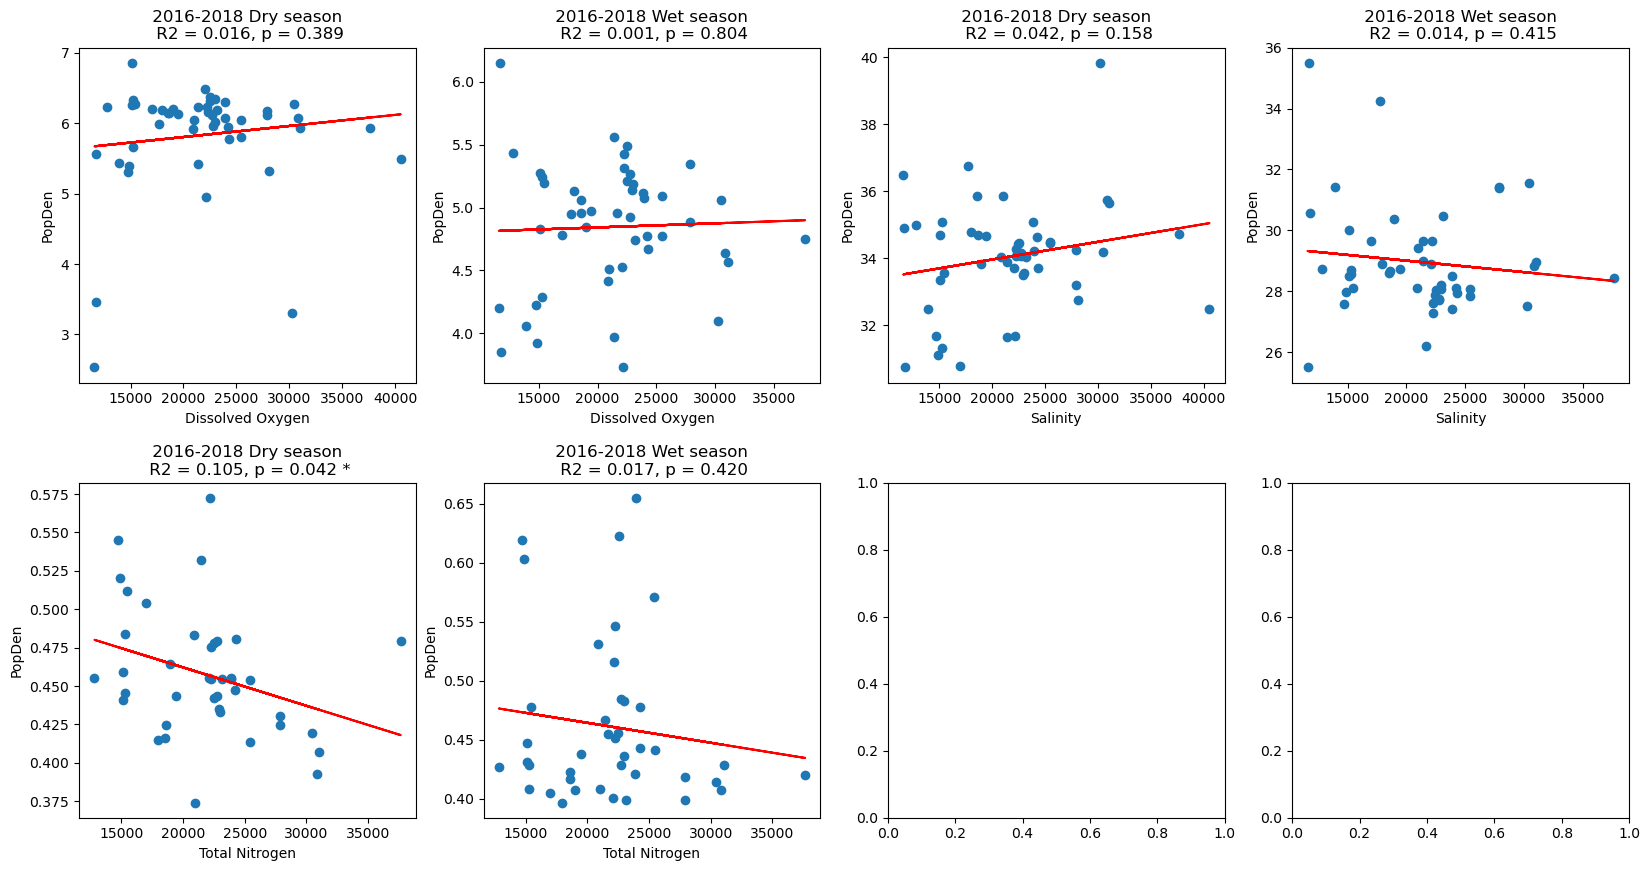

In [54]:
misc.covariateCopy.plot_regression(outputs_PopDen[outputs_PopDen['Area'] == 'Biscayne_Bay'])

### 4.4.5 Water Flow (combined_waterflow_results)  <a class="anchor" id="reg_result_bbap_wf"></a>

In [55]:
combined_waterflow_results[combined_waterflow_results['Area'] == 'Biscayne_Bay']

Dependent Independent          Area       Year Season  Coefficient  \
1   Dissolved Oxygen  Water_Flow  Biscayne_Bay  2016-2018    Dry     0.008985   
8   Dissolved Oxygen  Water_Flow  Biscayne_Bay  2016-2018    Wet     0.000634   
14          Salinity  Water_Flow  Biscayne_Bay  2016-2018    Wet    -0.005417   
18          Salinity  Water_Flow  Biscayne_Bay  2016-2018    Dry     0.015272   
22    Total Nitrogen  Water_Flow  Biscayne_Bay  2016-2018    Wet     0.000053   
26    Total Nitrogen  Water_Flow  Biscayne_Bay  2016-2018    Dry    -0.003181   

    R-squared   p-value  
1    0.152560  0.006 **  
8    0.053857     0.112  
14   0.311156  0.000 **  
18   0.103224   0.024 *  
22   0.001672     0.800  
26   0.169797  0.008 **

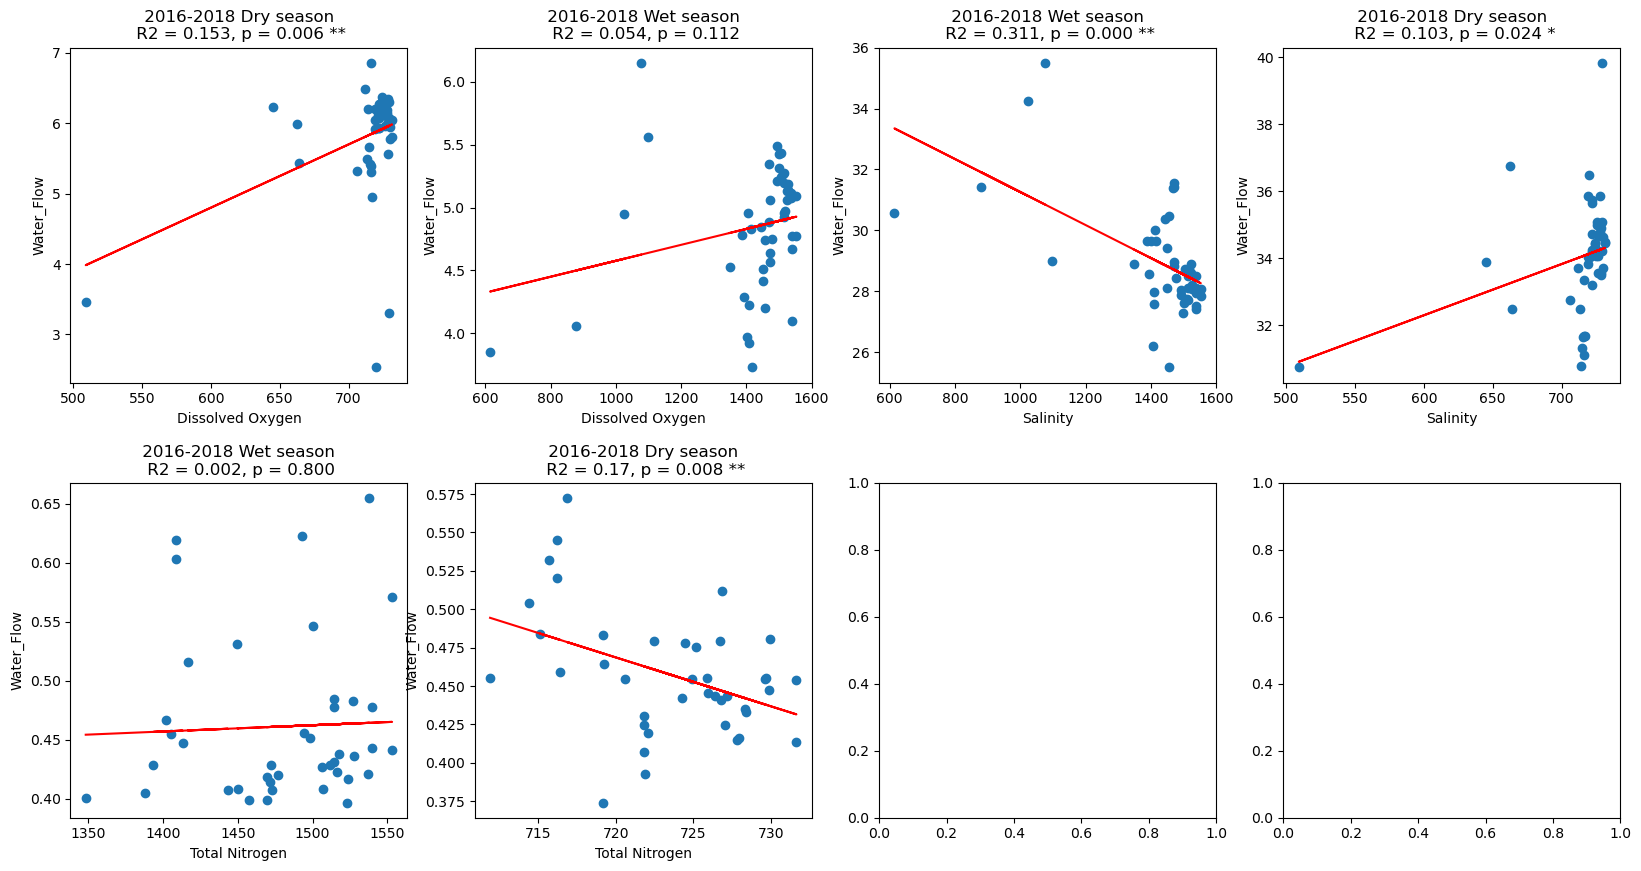

In [56]:
misc.covariateCopy.plot_regression(combined_waterflow_outputs[combined_waterflow_outputs['Area'] == 'Biscayne_Bay'])

## 4.5 Matlacha Pass Aquatic Preserve  <a class="anchor" id="reg_result_mp"></a>
### 4.5.1 Water Depth  <a class="anchor" id="reg_result_mp_wd"></a>

In [57]:
results_WD[results_WD['Area'] == 'Matlacha_Pass']

Dependent  Independent           Area       Year Season  \
4   Dissolved Oxygen  Water_Depth  Matlacha_Pass  2016-2018    Dry   
9   Dissolved Oxygen  Water_Depth  Matlacha_Pass  2016-2018    Wet   
14          Salinity  Water_Depth  Matlacha_Pass  2016-2018    Dry   
19          Salinity  Water_Depth  Matlacha_Pass  2016-2018    Wet   
24    Total Nitrogen  Water_Depth  Matlacha_Pass  2016-2018    Dry   
29    Total Nitrogen  Water_Depth  Matlacha_Pass  2016-2018    Wet   

    Coefficient  R-squared p-value  
4      0.087597   0.032683   0.258  
9     -0.032190   0.015511   0.715  
14    -0.056945   0.000908   0.859  
19     0.159355   0.096033   0.455  
24     0.030054   0.163120   0.321  
29     0.007643   0.070229   0.612

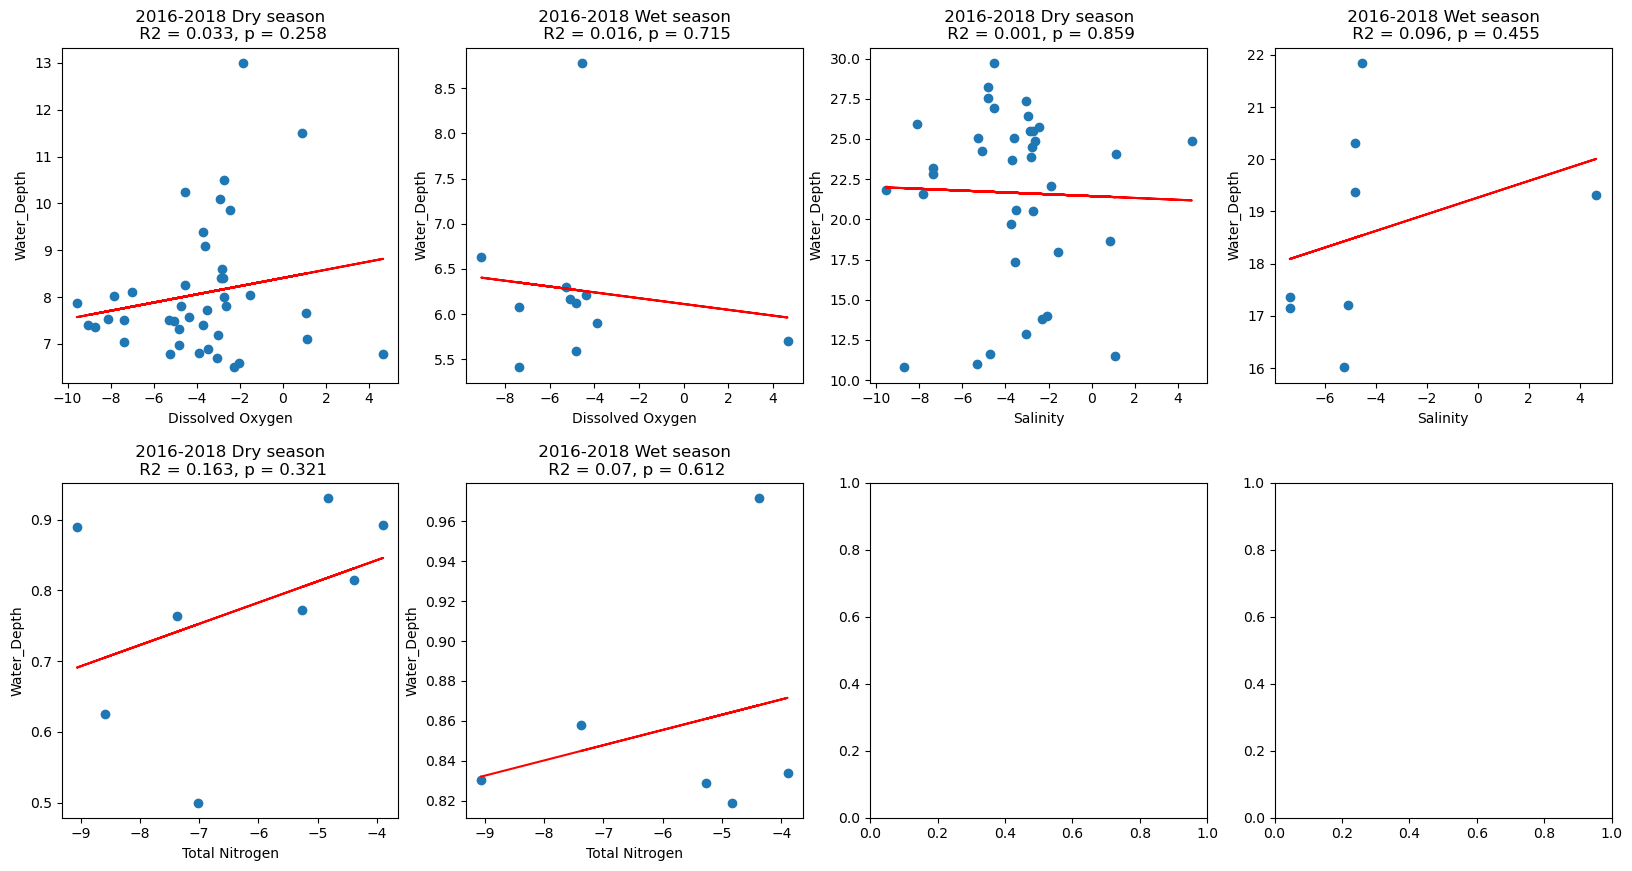

In [58]:
misc.covariateCopy.plot_regression(outputs_WD[outputs_WD['Area'] == 'Matlacha_Pass'])

### 4.5.2 Land development index (LDI_HUC_LSS)  <a class="anchor" id="reg_result_mp_ldi"></a>

In [59]:
results_LDI_HUC_LSS[results_LDI_HUC_LSS['Area'] == 'Matlacha_Pass']

Dependent  Independent           Area       Year Season  \
4   Dissolved Oxygen  LDI_HUC_LSS  Matlacha_Pass  2016-2018    Dry   
9   Dissolved Oxygen  LDI_HUC_LSS  Matlacha_Pass  2016-2018    Wet   
14          Salinity  LDI_HUC_LSS  Matlacha_Pass  2016-2018    Dry   
19          Salinity  LDI_HUC_LSS  Matlacha_Pass  2016-2018    Wet   
24    Total Nitrogen  LDI_HUC_LSS  Matlacha_Pass  2016-2018    Dry   
29    Total Nitrogen  LDI_HUC_LSS  Matlacha_Pass  2016-2018    Wet   

    Coefficient  R-squared p-value  
4     -0.203701   0.075176   0.083  
9     -0.076028   0.041725   0.547  
14    -0.320179   0.013290   0.497  
19    -0.246487   0.121558   0.397  
24    -0.001006   0.000187   0.974  
29    -0.000600   0.000563   0.964

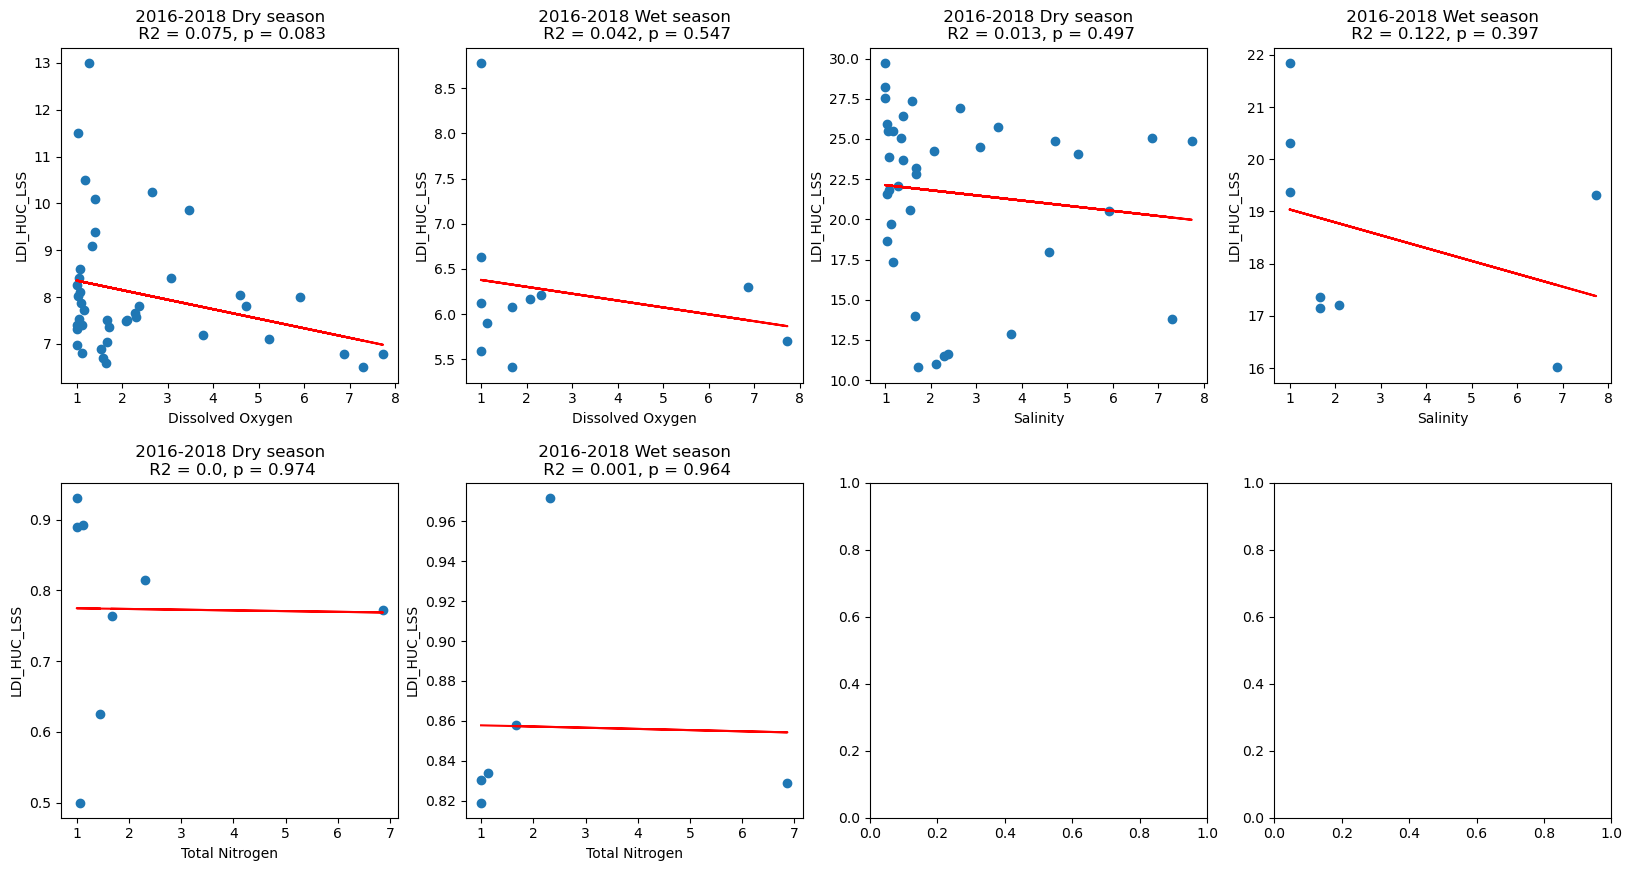

In [60]:
misc.covariateCopy.plot_regression(outputs_LDI_HUC_LSS[outputs_WD['Area'] == 'Matlacha_Pass'])

### 4.5.3 Land development index (New_LDI_HUC_LSS)  <a class="anchor" id="reg_result_mp_new_ldi"></a>

In [61]:
results_New_LDI_HUC_LSS[results_New_LDI_HUC_LSS['Area'] == 'Matlacha_Pass']

Dependent      Independent           Area       Year Season  \
4   Dissolved Oxygen  New_LDI_HUC_LSS  Matlacha_Pass  2016-2018    Dry   
9   Dissolved Oxygen  New_LDI_HUC_LSS  Matlacha_Pass  2016-2018    Wet   
14          Salinity  New_LDI_HUC_LSS  Matlacha_Pass  2016-2018    Dry   
19          Salinity  New_LDI_HUC_LSS  Matlacha_Pass  2016-2018    Wet   
24    Total Nitrogen  New_LDI_HUC_LSS  Matlacha_Pass  2016-2018    Dry   
29    Total Nitrogen  New_LDI_HUC_LSS  Matlacha_Pass  2016-2018    Wet   

    Coefficient  R-squared p-value  
4     -0.204829   0.076227   0.081  
9     -0.076026   0.041723   0.547  
14    -0.322184   0.013498   0.493  
19    -0.246456   0.121530   0.397  
24    -0.001012   0.000189   0.974  
29    -0.000600   0.000563   0.964

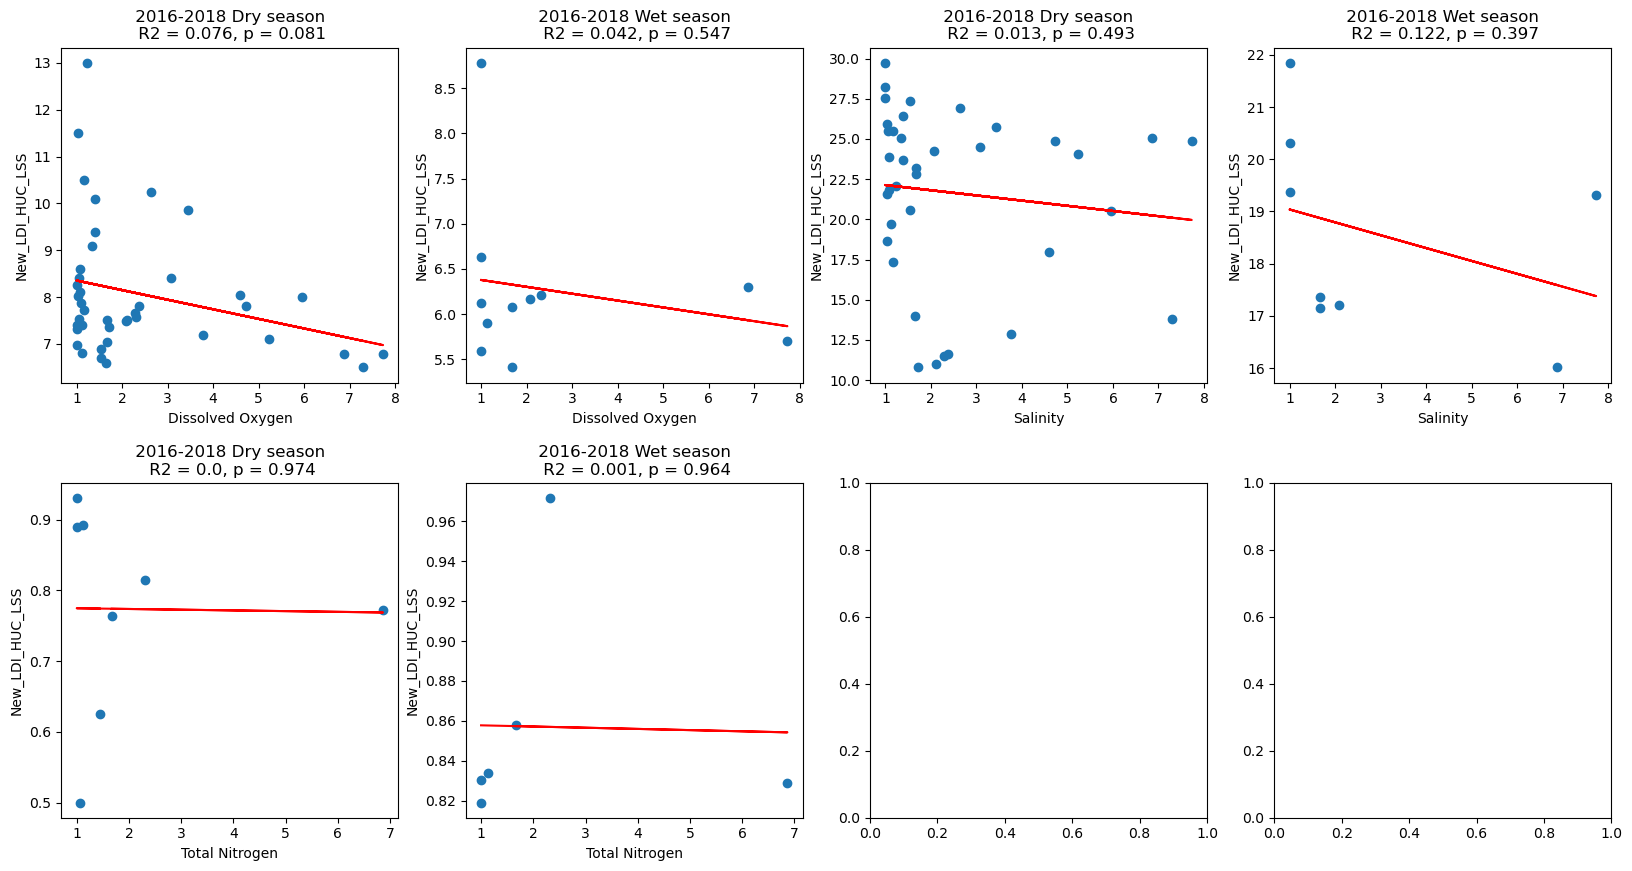

In [62]:
misc.covariateCopy.plot_regression(outputs_New_LDI_HUC_LSS[outputs_New_LDI_HUC_LSS['Area'] == 'Matlacha_Pass'])

### 4.5.4 Population Density (PopDen)  <a class="anchor" id="reg_result_mp_popden"></a>

In [63]:
results_PopDen[results_PopDen['Area'] == 'Matlacha_Pass']

Dependent Independent           Area       Year Season  \
4   Dissolved Oxygen      PopDen  Matlacha_Pass  2016-2018    Dry   
9   Dissolved Oxygen      PopDen  Matlacha_Pass  2016-2018    Wet   
14          Salinity      PopDen  Matlacha_Pass  2016-2018    Dry   
19          Salinity      PopDen  Matlacha_Pass  2016-2018    Wet   
24    Total Nitrogen      PopDen  Matlacha_Pass  2016-2018    Dry   
29    Total Nitrogen      PopDen  Matlacha_Pass  2016-2018    Wet   

     Coefficient  R-squared   p-value  
4  -1.134822e-03   0.199758  0.003 **  
9  -5.454541e-04   0.150552     0.238  
14 -3.407089e-03   0.130439   0.028 *  
19 -1.778618e-03   0.411238     0.087  
24  2.981938e-05   0.017286     0.756  
29 -7.863938e-07   0.000088     0.986

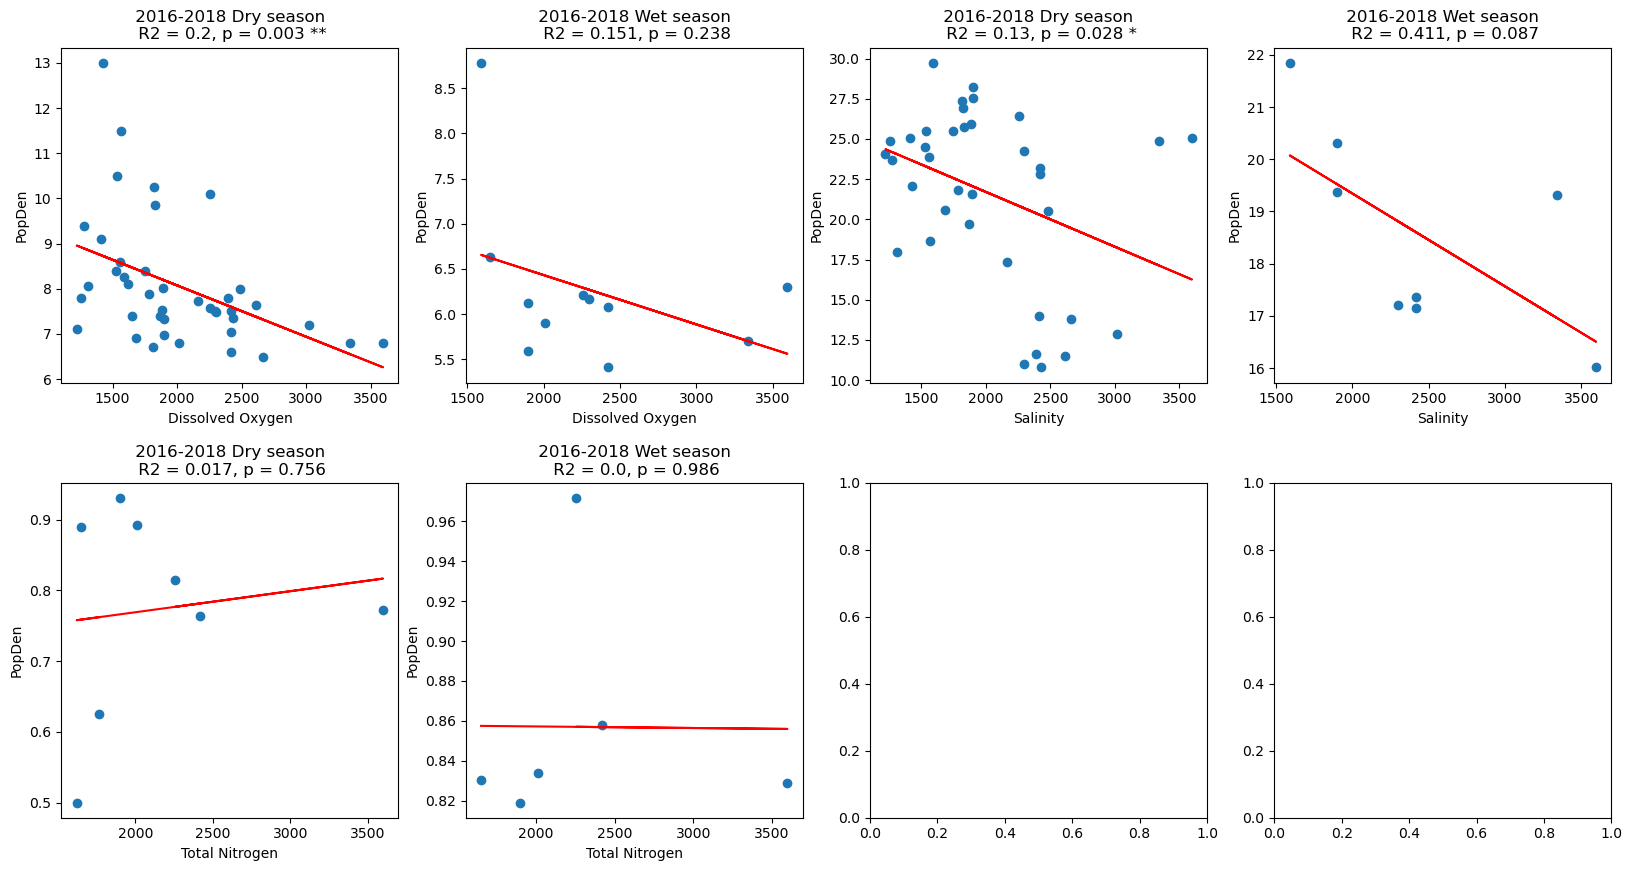

In [64]:
misc.covariateCopy.plot_regression(outputs_PopDen[outputs_PopDen['Area'] == 'Matlacha_Pass'])

### 4.5.5 Water Flow (combined_waterflow_results)  <a class="anchor" id="reg_result_mp_wf"></a>

In [65]:
combined_waterflow_results[combined_waterflow_results['Area'] == 'Matlacha_Pass']

Dependent Independent           Area       Year Season  \
4   Dissolved Oxygen  Water_Flow  Matlacha_Pass  2016-2018    Dry   
5   Dissolved Oxygen  Water_Flow  Matlacha_Pass  2016-2018    Wet   
12          Salinity  Water_Flow  Matlacha_Pass  2016-2018    Wet   
15          Salinity  Water_Flow  Matlacha_Pass  2016-2018    Dry   
23    Total Nitrogen  Water_Flow  Matlacha_Pass  2016-2018    Dry   
29    Total Nitrogen  Water_Flow  Matlacha_Pass  2016-2018    Wet   

    Coefficient  R-squared   p-value  
4     -0.000189   0.052072     0.151  
5     -0.000142   0.091552     0.366  
12    -0.000587   0.398308     0.093  
15    -0.001410   0.201481  0.005 **  
23     0.000012   0.027186     0.696  
29     0.000013   0.189618     0.388

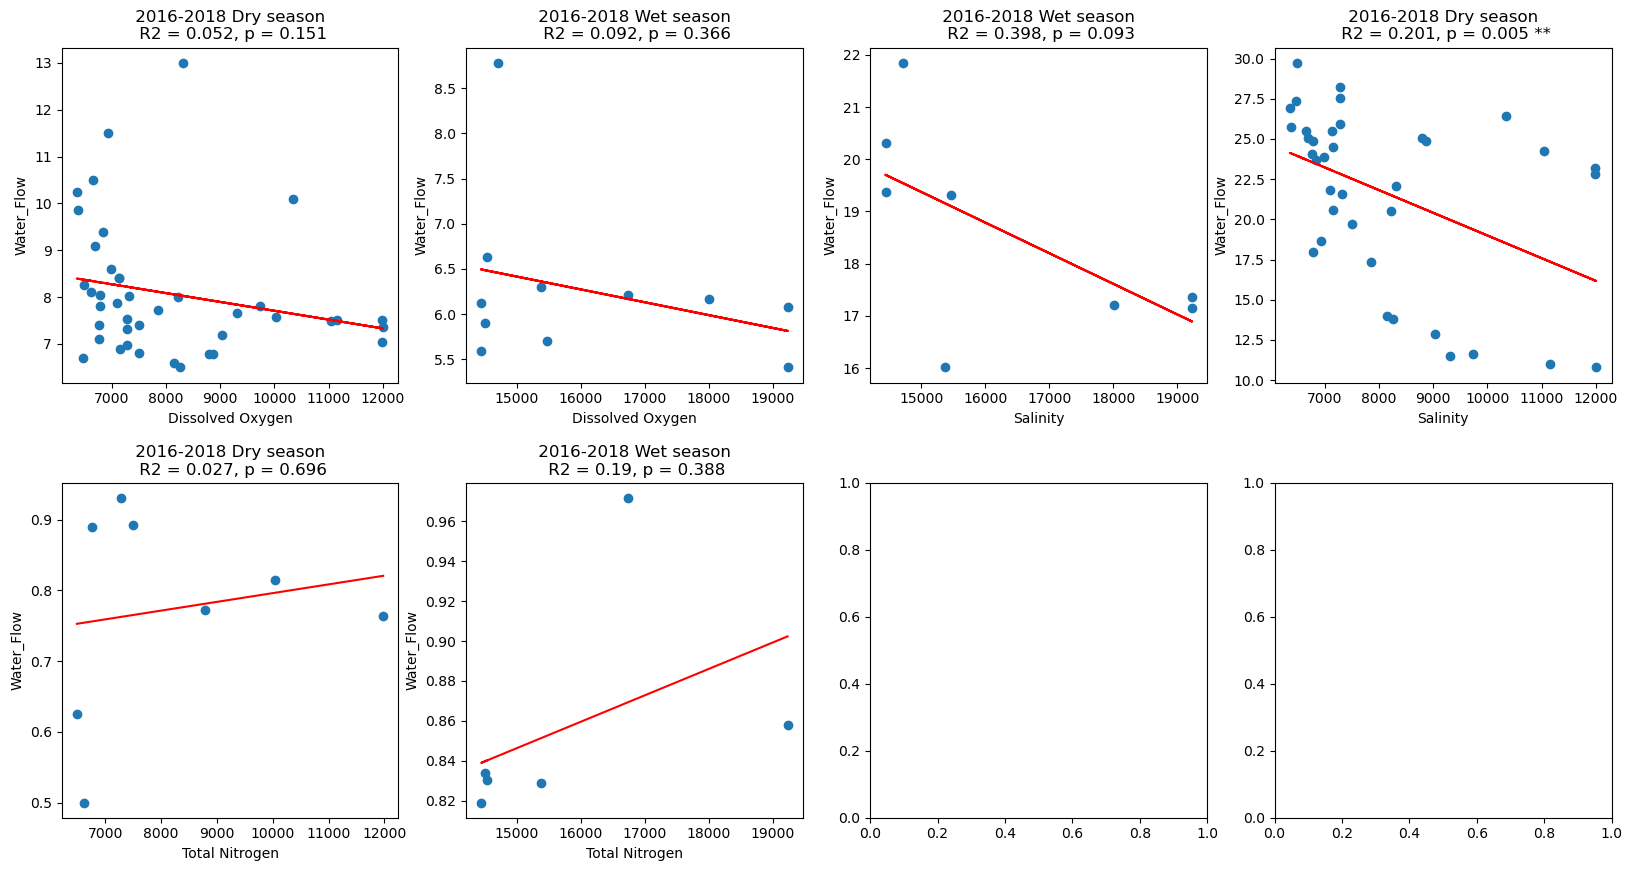

In [66]:
misc.covariateCopy.plot_regression(combined_waterflow_outputs[combined_waterflow_outputs['Area'] == 'Matlacha_Pass'])